<a href="https://colab.research.google.com/github/vivek6015/Fantasy-Football/blob/main/Fantasy_Football_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blueprint

In [3]:
# WIDE RECEIVER PROJECTION SYSTEM - REUSABLE BLUEPRINT
# Consolidates all projection methodologies into configurable functions

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# ============================================================================
# CONFIGURATION - UPDATE THESE VALUES EACH WEEK
# ============================================================================

WEEK_NUMBER = 12  # Change this each week
WR_FILE = f"WR{WEEK_NUMBER}.csv"
DEFENSE_FILE = f"Defense{WEEK_NUMBER}.csv"
RESULTS_FILE = f"WR{WEEK_NUMBER}Results.csv"  # Only needed for retrospective analysis

# ============================================================================
# DATA LOADING FUNCTIONS
# ============================================================================

def load_projection_data(wr_file, defense_file):
    """
    Load and merge WR and defense data for projections.

    Args:
        wr_file: Path to WR CSV file
        defense_file: Path to Defense CSV file

    Returns:
        DataFrame with merged WR and defense data
    """
    wr = pd.read_csv(wr_file)
    defense = pd.read_csv(defense_file)
    defense.rename(columns={'Next Opp': 'Team'}, inplace=True)
    wr = wr.merge(defense, how='inner', on='Team')
    wr = wr.sort_values('Total Points', ascending=False)
    return wr


def load_results_data(wr_data, results_file):
    """
    Merge actual results with projection data for retrospective analysis.

    Args:
        wr_data: DataFrame with projection data
        results_file: Path to results CSV file

    Returns:
        DataFrame with projections and actual results
    """
    results = pd.read_csv(results_file)
    results.rename(columns={'NAME': 'Player'}, inplace=True)
    wr_with_results = wr_data.merge(results, how='inner', on='Player')
    return wr_with_results


def calculate_projections(wr_data):
    """
    Calculate all projection types for WR data.

    Args:
        wr_data: DataFrame with WR and defense data

    Returns:
        DataFrame with added projection columns
    """
    wr_data["Slot Projection"] = wr_data["Slot PPG"] * wr_data["Slot PPG Allowed"]
    wr_data["Wide Projection"] = wr_data["Wide PPG"] * wr_data["Wide PPG Allowed"]
    wr_data["Both Projection"] = wr_data["Slot Projection"] + wr_data["Wide Projection"]
    wr_data["Total Projection"] = wr_data["Total Points"] * wr_data["Total PPG Allowed"]
    return wr_data


# ============================================================================
# TIER CREATION FUNCTIONS
# ============================================================================

def create_position_tiers(wr_data):
    """
    Create tier-based subsets for slot and wide receivers.

    Args:
        wr_data: DataFrame with WR data

    Returns:
        Dictionary containing different tier DataFrames
    """
    tiers = {
        'slot_16': wr_data.sort_values("Slot PPG", ascending=False).head(16),
        'slot_32': wr_data.sort_values("Slot PPG", ascending=False).head(32),
        'slot_64': wr_data.sort_values("Slot PPG", ascending=False).head(64),
        'wide_16': wr_data.sort_values("Wide PPG", ascending=False).head(16),
        'wide_32': wr_data.sort_values("Wide PPG", ascending=False).head(32),
        'wide_64': wr_data.sort_values("Wide PPG", ascending=False).head(64),
        'all': wr_data
    }
    return tiers


# ============================================================================
# REGRESSION AND ANALYSIS FUNCTIONS
# ============================================================================

def calculate_regression(x_data, y_data):
    """
    Calculate linear regression coefficients.

    Args:
        x_data: Independent variable data
        y_data: Dependent variable data

    Returns:
        Tuple of (slope, intercept)
    """
    coeffs = np.polyfit(x_data, y_data, 1)
    return coeffs[0], coeffs[1]


def plot_projection_scatter(data, x_col, y_col, title="Projection Analysis",
                            add_labels=False, label_top_n=None):
    """
    Create scatter plot with line of best fit.

    Args:
        data: DataFrame containing the data
        x_col: Column name for x-axis
        y_col: Column name for y-axis
        title: Plot title
        add_labels: Whether to add player name labels
        label_top_n: Number of top players to label (if None, labels all)
    """
    data.plot(kind="scatter", x=x_col, y=y_col)

    # Calculate and plot line of best fit
    slope, intercept = calculate_regression(data[x_col], data[y_col])
    line = np.poly1d([slope, intercept])
    plt.plot(data[x_col], line(data[x_col]), "r-", linewidth=2,
             label=f'y={slope:.2f}x+{intercept:.2f}')

    # Add player labels if requested
    if add_labels:
        data_to_label = data.head(label_top_n) if label_top_n else data
        for idx, row in data_to_label.iterrows():
            plt.text(row[x_col] + 0.1, row[y_col] + 0.1,
                    row["Player"], fontsize=8)

    plt.title(title)
    plt.legend()
    plt.show()

    return slope, intercept


def calculate_correlation(data, x_col, y_col):
    """
    Calculate correlation coefficient between two columns.

    Args:
        data: DataFrame containing the data
        x_col: First column name
        y_col: Second column name

    Returns:
        Correlation coefficient
    """
    return data[x_col].corr(data[y_col])


# ============================================================================
# TIER-SPECIFIC REGRESSION FUNCTIONS (for V4 methodology)
# ============================================================================

def get_tier_regression(df, tier_start, tier_end, projection_col):
    """
    Calculate regression line for a specific tier range.

    Args:
        df: DataFrame sorted by appropriate metric
        tier_start: Starting index for tier
        tier_end: Ending index for tier
        projection_col: Column name for projection values

    Returns:
        Tuple of (slope, intercept)
    """
    tier_data = df.iloc[tier_start:tier_end]
    if len(tier_data) > 1:
        coeffs = np.polyfit(tier_data["Total Points"], tier_data[projection_col], 1)
        return coeffs[0], coeffs[1]
    return 1, 0


def get_expected_value(rank, ppg, slope_t1, int_t1, slope_t2, int_t2, slope_t3, int_t3):
    """
    Get expected projection value based on player's tier.

    Args:
        rank: Player's rank in the position
        ppg: Player's points per game
        slope_t1, int_t1: Tier 1 (0-16) regression coefficients
        slope_t2, int_t2: Tier 2 (16-32) regression coefficients
        slope_t3, int_t3: Tier 3 (32-64) regression coefficients

    Returns:
        Expected projection value
    """
    if rank < 16:
        return slope_t1 * ppg + int_t1
    elif rank < 32:
        return slope_t2 * ppg + int_t2
    else:
        return slope_t3 * ppg + int_t3


def calculate_tiered_projections(wr_data):
    """
    Calculate weekly projections using tier-specific regression (V4 methodology).

    Args:
        wr_data: DataFrame with WR projection data

    Returns:
        DataFrame with weekly projections sorted by projection value
    """
    # Sort by position type
    wr_slot = wr_data.sort_values("Slot PPG", ascending=False).reset_index(drop=True)
    wr_wide = wr_data.sort_values("Wide PPG", ascending=False).reset_index(drop=True)

    # Calculate tier-specific regressions for Slot
    slot_t1_slope, slot_t1_int = get_tier_regression(wr_slot, 0, 16, "Slot Projection")
    slot_t2_slope, slot_t2_int = get_tier_regression(wr_slot, 16, 32, "Slot Projection")
    slot_t3_slope, slot_t3_int = get_tier_regression(wr_slot, 32, 64, "Slot Projection")

    # Calculate tier-specific regressions for Wide
    wide_t1_slope, wide_t1_int = get_tier_regression(wr_wide, 0, 16, "Wide Projection")
    wide_t2_slope, wide_t2_int = get_tier_regression(wr_wide, 16, 32, "Wide Projection")
    wide_t3_slope, wide_t3_int = get_tier_regression(wr_wide, 32, 64, "Wide Projection")

    # Calculate projections for each player
    results = []

    for idx, player_row in wr_data.iterrows():
        player_name = player_row["Player"]
        ppg = player_row["Total Points"]
        slot_ppg = player_row["Slot PPG"]
        wide_ppg = player_row["Wide PPG"]

        # Find player's rank
        slot_rank = wr_slot[wr_slot["Player"] == player_name].index[0] if player_name in wr_slot["Player"].values else 999
        wide_rank = wr_wide[wr_wide["Player"] == player_name].index[0] if player_name in wr_wide["Player"].values else 999

        # Get actual projections
        slot_proj = player_row["Slot Projection"]
        wide_proj = player_row["Wide Projection"]

        # Get expected values based on tier
        slot_expected = get_expected_value(slot_rank, ppg, slot_t1_slope, slot_t1_int,
                                          slot_t2_slope, slot_t2_int, slot_t3_slope, slot_t3_int)
        wide_expected = get_expected_value(wide_rank, ppg, wide_t1_slope, wide_t1_int,
                                          wide_t2_slope, wide_t2_int, wide_t3_slope, wide_t3_int)

        # Divide projection by expected, multiply by respective PPG
        slot_adjusted = (slot_proj / slot_expected) * slot_ppg if slot_expected > 0 else slot_ppg
        wide_adjusted = (wide_proj / wide_expected) * wide_ppg if wide_expected > 0 else wide_ppg

        # Weekly projection = sum of adjusted values
        weekly_projection = slot_adjusted + wide_adjusted

        results.append({
            'Player': player_name,
            'PPG': ppg,
            'Slot PPG': slot_ppg,
            'Wide PPG': wide_ppg,
            'Slot Rank': slot_rank + 1,
            'Wide Rank': wide_rank + 1,
            'Slot Multiplier': slot_proj / slot_expected if slot_expected > 0 else 1,
            'Wide Multiplier': wide_proj / wide_expected if wide_expected > 0 else 1,
            'Slot Adjusted': slot_adjusted,
            'Wide Adjusted': wide_adjusted,
            'Week Projection': weekly_projection,
            'Difference': weekly_projection - ppg
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Week Projection', ascending=False).reset_index(drop=True)

    return results_df


# ============================================================================
# ANALYSIS FUNCTIONS
# ============================================================================

def identify_favorable_matchups(data, x_col, projection_col, ppg_threshold=None):
    """
    Identify players with favorable matchups (above expected projection).

    Args:
        data: DataFrame with player data
        x_col: Column to use for x-axis (usually "Total Points")
        projection_col: Column with projection values
        ppg_threshold: Optional PPG threshold for filtering

    Returns:
        List of dictionaries with player info for favorable matchups
    """
    slope, intercept = calculate_regression(data[x_col], data[projection_col])

    favorable = []
    for idx, row in data.iterrows():
        expected = slope * row[x_col] + intercept
        if row[projection_col] > expected:
            if ppg_threshold is None or row[x_col] >= ppg_threshold:
                favorable.append({
                    'Player': row['Player'],
                    'PPG': row[x_col],
                    'Projection': row[projection_col],
                    'Expected': expected,
                    'Diff': row[projection_col] - expected
                })

    return favorable


def identify_unfavorable_matchups(data, x_col, projection_col, ppg_threshold=15):
    """
    Identify players with unfavorable matchups (below expected projection).

    Args:
        data: DataFrame with player data
        x_col: Column to use for x-axis (usually "Total Points")
        projection_col: Column with projection values
        ppg_threshold: PPG threshold for filtering (default 15)

    Returns:
        List of dictionaries with player info for unfavorable matchups
    """
    slope, intercept = calculate_regression(data[x_col], data[projection_col])

    unfavorable = []
    for idx, row in data.iterrows():
        expected = slope * row[x_col] + intercept
        if row[projection_col] < expected and row[x_col] < ppg_threshold:
            unfavorable.append({
                'Player': row['Player'],
                'PPG': row[x_col],
                'Projection': row[projection_col],
                'Expected': expected,
                'Diff': row[projection_col] - expected
            })

    return unfavorable


def print_matchup_analysis(favorable, unfavorable, title="Matchup Analysis"):
    """
    Print formatted matchup analysis results.

    Args:
        favorable: List of favorable matchup dictionaries
        unfavorable: List of unfavorable matchup dictionaries
        title: Title for the analysis section
    """
    print("\n" + "=" * 80)
    print(f"{title} - FAVORABLE MATCHUPS (Consider Starting)")
    print("=" * 80)
    for player in favorable:
        print(f"{player['Player']}")
        print(f"  PPG: {player['PPG']:.2f}")
        print(f"  Projection: {player['Projection']:.2f} (Expected: {player['Expected']:.2f})")
        print(f"  Diff: {player['Diff']:.2f}")

    print("\n" + "=" * 80)
    print(f"{title} - UNFAVORABLE MATCHUPS (Consider Benching)")
    print("=" * 80)
    for player in unfavorable:
        print(f"{player['Player']}")
        print(f"  PPG: {player['PPG']:.2f}")
        print(f"  Projection: {player['Projection']:.2f} (Expected: {player['Expected']:.2f})")
        print(f"  Diff: {player['Diff']:.2f}")


def run_correlation_analysis(data, has_results=False):
    """
    Run comprehensive correlation analysis on projections.

    Args:
        data: DataFrame with projection data
        has_results: Whether actual results (FPTS) are available

    Returns:
        Dictionary of correlation coefficients
    """
    correlations = {}

    if has_results:
        # Correlations with actual results
        correlations['Both vs FPTS'] = calculate_correlation(data, "Both Projection", "FPTS")
        correlations['Total vs FPTS'] = calculate_correlation(data, "Total Projection", "FPTS")
        correlations['Wide vs FPTS'] = calculate_correlation(data, "Wide Projection", "FPTS")
        correlations['Slot vs FPTS'] = calculate_correlation(data, "Slot Projection", "FPTS")
    else:
        # Correlations between projection types
        correlations['Both vs Total'] = calculate_correlation(data, "Both Projection", "Total Projection")
        correlations['Wide vs Slot'] = calculate_correlation(data, "Wide Projection", "Slot Projection")

    return correlations


def print_correlation_results(correlations):
    """
    Print formatted correlation analysis results.

    Args:
        correlations: Dictionary of correlation coefficients
    """
    print("\n" + "=" * 80)
    print("CORRELATION ANALYSIS")
    print("=" * 80)
    for name, corr in correlations.items():
        print(f"{name}: {corr:.4f}")


def print_tiered_projections(results_df, start_rank=0, end_rank=32):
    """
    Print tiered projection results in formatted table.

    Args:
        results_df: DataFrame with projection results
        start_rank: Starting rank to display (0-indexed)
        end_rank: Ending rank to display
    """
    rank_range = f"RANKS {start_rank+1}-{end_rank}" if start_rank > 0 else f"TOP {end_rank}"

    print("\n" + "=" * 90)
    print(f"WEEKLY PROJECTIONS - {rank_range} WIDE RECEIVERS")
    print("=" * 90)
    print(f"{'Rank':<6}{'Player':<25}{'PPG':<8}{'Proj':<8}{'Diff':<8}{'Slot Adj':<10}{'Wide Adj':<10}")
    print("-" * 90)

    for idx, row in results_df.iloc[start_rank:end_rank].iterrows():
        print(f"{idx+1:<6}{row['Player']:<25}{row['PPG']:<8.2f}{row['Week Projection']:<8.2f}"
              f"{row['Difference']:<8.2f}{row['Slot Adjusted']:<10.2f}{row['Wide Adjusted']:<10.2f}")


def visualize_tiered_projections(results_df, top_n=32):
    """
    Create visualizations for tiered projection system.

    Args:
        results_df: DataFrame with projection results
        top_n: Number of top players to visualize
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    top_players = results_df.head(top_n)

    # Plot 1: Week Projection vs PPG
    colors = ['green' if diff > 0 else 'red' for diff in top_players['Difference']]
    ax1.scatter(top_players['PPG'], top_players['Week Projection'], c=colors, alpha=0.6, s=100)
    ax1.plot([0, top_players['PPG'].max()], [0, top_players['PPG'].max()],
             'k--', alpha=0.3, label='PPG Baseline')
    ax1.set_xlabel('Season PPG', fontsize=12)
    ax1.set_ylabel('Week Projection', fontsize=12)
    ax1.set_title(f'Weekly Projection vs Season Average (Top {top_n})', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add labels for top 10
    for idx, row in top_players.head(10).iterrows():
        ax1.annotate(row['Player'], (row['PPG'], row['Week Projection']),
                    fontsize=8, alpha=0.7, xytext=(5, 5), textcoords='offset points')

    # Plot 2: Difference from PPG
    ax2.barh(range(len(top_players)), top_players['Difference'],
             color=['green' if x > 0 else 'red' for x in top_players['Difference']])
    ax2.set_yticks(range(len(top_players)))
    ax2.set_yticklabels(top_players['Player'], fontsize=8)
    ax2.set_xlabel('Difference from Season PPG', fontsize=12)
    ax2.set_title(f'Projected vs Average Performance (Top {top_n})', fontsize=14, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax2.grid(True, alpha=0.3, axis='x')
    ax2.invert_yaxis()

    plt.tight_layout()
    plt.show()


def print_tiered_summary(results_df, top_n=32):
    """
    Print summary statistics for tiered projections.

    Args:
        results_df: DataFrame with projection results
        top_n: Number of top players to analyze
    """
    top_players = results_df.head(top_n)

    print("\n" + "=" * 90)
    print("SUMMARY STATISTICS")
    print("=" * 90)
    print(f"Average projection for top {top_n}: {top_players['Week Projection'].mean():.2f} points")
    print(f"Average PPG for top {top_n}: {top_players['PPG'].mean():.2f} points")
    print(f"Players projected above average: {len(top_players[top_players['Difference'] > 0])}")
    print(f"Players projected below average: {len(top_players[top_players['Difference'] < 0])}")
    print(f"Highest projection: {top_players['Player'].iloc[0]} ({top_players['Week Projection'].iloc[0]:.2f})")

    if len(top_players[top_players['Difference'] > 0]) > 0:
        max_idx = top_players['Difference'].idxmax()
        print(f"Biggest positive difference: {top_players['Player'].iloc[max_idx]} (+{top_players['Difference'].max():.2f})")

    if len(top_players[top_players['Difference'] < 0]) > 0:
        min_idx = top_players['Difference'].idxmin()
        print(f"Biggest negative difference: {top_players['Player'].iloc[min_idx]} ({top_players['Difference'].min():.2f})")


# ============================================================================
# MAIN EXECUTION WORKFLOWS
# ============================================================================

def run_basic_projection_analysis(week_number):
    """
    V1: Basic projection calculation and display.
    """
    print(f"\n{'='*80}")
    print(f"RUNNING V1: BASIC PROJECTION ANALYSIS - WEEK {week_number}")
    print(f"{'='*80}\n")

    wr = load_projection_data(f"WR{week_number}.csv", f"Defense{week_number}.csv")
    wr = calculate_projections(wr)
    print(wr.to_string())


def run_regression_analysis(week_number, tier_size=16, position='slot'):
    """
    V2: Regression analysis with scatter plots and matchup identification.
    """
    print(f"\n{'='*80}")
    print(f"RUNNING V2: REGRESSION ANALYSIS - WEEK {week_number}")
    print(f"{'='*80}\n")

    wr = load_projection_data(f"WR{week_number}.csv", f"Defense{week_number}.csv")
    wr = calculate_projections(wr)

    # Create appropriate tier
    if position == 'slot':
        tier_data = wr.sort_values("Slot PPG", ascending=False).head(tier_size)
        proj_col = "Slot Projection"
    else:
        tier_data = wr.sort_values("Wide PPG", ascending=False).head(tier_size)
        proj_col = "Wide Projection"

    # Plot and analyze
    plot_projection_scatter(tier_data, "Total Points", proj_col,
                           title=f"Top {tier_size} {position.title()} Receivers",
                           add_labels=True)

    favorable = identify_favorable_matchups(tier_data, "Total Points", proj_col)
    unfavorable = identify_unfavorable_matchups(tier_data, "Total Points", proj_col)

    print_matchup_analysis(favorable, unfavorable,
                          title=f"Top {tier_size} {position.title()} Receivers")


def run_comprehensive_analysis(week_number):
    """
    V3: Comprehensive analysis across multiple tiers and projection types.
    """
    print(f"\n{'='*80}")
    print(f"RUNNING V3: COMPREHENSIVE MULTI-TIER ANALYSIS - WEEK {week_number}")
    print(f"{'='*80}\n")

    wr = load_projection_data(f"WR{week_number}.csv", f"Defense{week_number}.csv")
    wr = calculate_projections(wr)
    tiers = create_position_tiers(wr)

    # Analyze different projection types on full dataset
    for proj_type in ["Total Projection", "Both Projection"]:
        print(f"\n--- {proj_type} Analysis (Top 64) ---")
        plot_projection_scatter(tiers['all'].head(64), "Total Points", proj_type,
                               title=f"{proj_type} vs PPG")
        favorable = identify_favorable_matchups(tiers['all'].head(64),
                                               "Total Points", proj_type)
        print(f"\nPlayers above expected {proj_type}:")
        for player in favorable:
            print(f"  {player['Player']}: {player['Projection']:.2f} "
                  f"(Expected: {player['Expected']:.2f}, Diff: +{player['Diff']:.2f})")

    # Analyze different tier sizes for each position
    for position in ['slot', 'wide']:
        for tier_size in [16, 32]:
            proj_col = f"{position.title()} Projection"
            tier_key = f"{position}_{tier_size}"

            print(f"\n--- {tier_size} Model: {position.title()} Analysis ---")
            plot_projection_scatter(tiers[tier_key], "Total Points", proj_col,
                                   title=f"Top {tier_size} {position.title()} Receivers",
                                   add_labels=(tier_size == 16))

            favorable = identify_favorable_matchups(tiers[tier_key],
                                                   "Total Points", proj_col)
            unfavorable = identify_unfavorable_matchups(tiers[tier_key],
                                                       "Total Points", proj_col)

            print_matchup_analysis(favorable, unfavorable,
                                 title=f"{tier_size} Model - {position.title()}")


def run_tiered_projection_system(week_number):
    """
    V4: Tier-specific regression projection system.
    """
    print(f"\n{'='*80}")
    print(f"RUNNING V4: TIERED PROJECTION SYSTEM - WEEK {week_number}")
    print(f"{'='*80}\n")

    wr = load_projection_data(f"WR{week_number}.csv", f"Defense{week_number}.csv")
    wr = calculate_projections(wr)

    # Calculate tiered projections
    results_df = calculate_tiered_projections(wr)

    # Display results
    print_tiered_projections(results_df, 0, 32)
    print_tiered_projections(results_df, 32, 64)

    # Visualize
    visualize_tiered_projections(results_df, top_n=32)

    # Summary
    print_tiered_summary(results_df, top_n=32)

    return results_df


def run_results_comparison(week_number, tier_analysis=False):
    """
    V5/V6: Compare projections against actual results.
    """
    print(f"\n{'='*80}")
    print(f"RUNNING V5/V6: RESULTS COMPARISON - WEEK {week_number}")
    print(f"{'='*80}\n")

    wr = load_projection_data(f"WR{week_number}.csv", f"Defense{week_number}.csv")
    wr = calculate_projections(wr)
    wr = load_results_data(wr, f"WR{week_number}Results.csv")

    if tier_analysis:
        # V5: Detailed tier analysis
        tiers = create_position_tiers(wr)

        for position in ['wide', 'slot']:
            for tier_size in [16, 32]:
                tier_key = f"{position}_{tier_size}"
                proj_col = f"{position.title()} Projection"

                print(f"\n--- {tier_size} {position.title()} vs Reality ---")
                slope, intercept = plot_projection_scatter(
                    tiers[tier_key], proj_col, "FPTS",
                    title=f"Top {tier_size} {position.title()} - Projection vs Actual",
                    add_labels=(tier_size == 16))

                corr = calculate_correlation(tiers[tier_key], proj_col, "FPTS")
                print(f"{tier_size} {position.title()} Projection correlation: {corr:.4f}")

        # All players analysis
        for proj_col in ["Wide Projection", "Slot Projection"]:
            print(f"\n--- All Players: {proj_col} vs Reality ---")
            plot_projection_scatter(wr, proj_col, "FPTS",
                                   title=f"All Players - {proj_col} vs Actual")
            corr = calculate_correlation(wr, proj_col, "FPTS")
            print(f"All {proj_col} correlation: {corr:.4f}")

    else:
        # V6: Simplified comparison
        print("\n--- Both Projection vs Reality ---")
        plot_projection_scatter(wr, "Both Projection", "FPTS",
                               title="Both Projection vs Actual FPTS")

        print("\n--- Total Projection vs Reality ---")
        plot_projection_scatter(wr, "Total Projection", "FPTS",
                               title="Total Projection vs Actual FPTS")

    # Correlation analysis
    correlations = run_correlation_analysis(wr, has_results=True)
    print_correlation_results(correlations)

# Choose which analysis to run:

# V1: Basic projection display
# run_basic_projection_analysis(WEEK)

# V2: Single tier regression analysis
# run_regression_analysis(WEEK, tier_size=16, position='slot')

# V3: Comprehensive multi-tier analysis
# run_comprehensive_analysis(WEEK)

# V4: Advanced tiered projection system (RECOMMENDED FOR WEEKLY PROJECTIONS)
# run_tiered_projection_system(WEEK)

# V5: Detailed results comparison with tier analysis (after week is complete)
# run_results_comparison(WEEK, tier_analysis=True)

# V6: Simplified results comparison (after week is complete)
# run_results_comparison(WEEK, tier_analysis=False)

# Week 7 Projections

In [ ]:
# MAKING SLOT AND WIDE PROJECTION BASED ON MATCHUP AND PREVIOUS GAMES

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

wr = pd.read_csv("WR#WeeksPlayed.csv")
defense = pd.read_csv("Defense#WeeksPlayed.csv")
defense.rename(columns={"Next Opp": 'Team'}, inplace = True)
wr = wr.merge(defense, how = "inner", on = "Team")
wr = wr.sort_values("Total Points", ascending = False)

wr["Slot Projection"] = wr["Slot PPG"] * wr["Slot PPG Allowed"]
# wr = wr.sort_values("Slot Projection", ascending=False)
# wr.nlargest(10, "Slot Projection")

wr["Wide Projection"] = wr["Wide PPG"] * wr["Wide PPG Allowed"]
# wr = wr.sort_values("Wide Projection", ascending=False)
# wr.nlargest(10, "Wide Projection")

wr["Total Projection"] = wr["Total Points"] * wr["Total PPG Allowed"]
# wr = wr.sort_values("Total Projection", ascending=False)
# wr.nlargest(10, "Total Projection")
print(wr.to_string())


# Week 7 Result Comparison

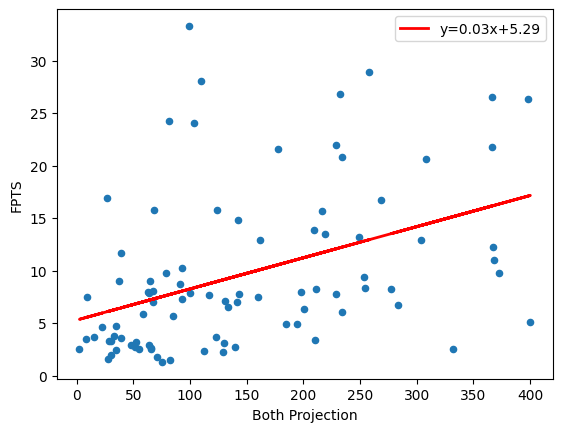

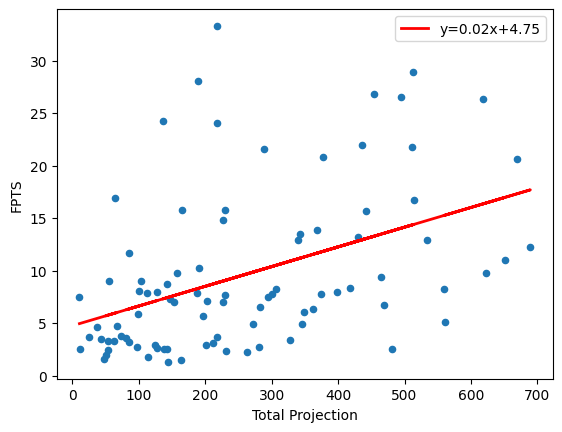

Both Projection correlation: 0.4166

Total Projection correlation: 0.4359



In [ ]:
# ADD WIDE VS SLOT PROJECTION COMPARED TO OVERALL PROJECTION, COMPARING BOTH TO FPTS

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

wr = pd.read_csv("WR6.csv")
defense = pd.read_csv("Defense6.csv")
defense.rename(columns={"Next Opp": 'Team'}, inplace = True)
wr = wr.merge(defense, how = "inner", on = "Team")
wr = wr.sort_values("Total Points", ascending = False)

results = pd.read_csv("WR6Results.csv")
results.rename(columns = {"NAME": "Player"}, inplace = True)
wr = wr.merge(results, how = "inner", on = "Player")

wr["Slot Projection"] = wr["Slot PPG"] * wr["Slot PPG Allowed"]
wr["Wide Projection"] = wr["Wide PPG"] * wr["Wide PPG Allowed"]
wr["Both Projection"] = wr["Slot Projection"] + wr["Wide Projection"]
wr["Total Projection"] = wr["Total Points"] * wr["Total PPG Allowed"]

# print(wr.to_string())

wr.plot(kind = "scatter", x = "Both Projection", y = "FPTS")
b = np.polyfit(wr["Both Projection"], wr["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr["Both Projection"], bline(wr["Both Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')

plt.legend()
plt.show()

wr.plot(kind = "scatter", x = "Total Projection", y = "FPTS")
t = np.polyfit(wr["Total Projection"], wr["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr["Total Projection"], tline(wr["Total Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')

plt.legend()
plt.show()

corr1 = wr["Both Projection"].corr(wr["FPTS"])
corr2 = wr["Total Projection"].corr(wr["FPTS"])
print(f"Both Projection correlation: {corr1:.4f}\n")
print(f"Total Projection correlation: {corr2:.4f}\n")

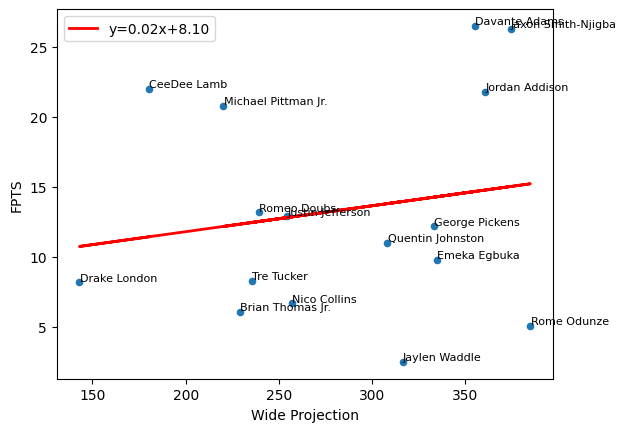

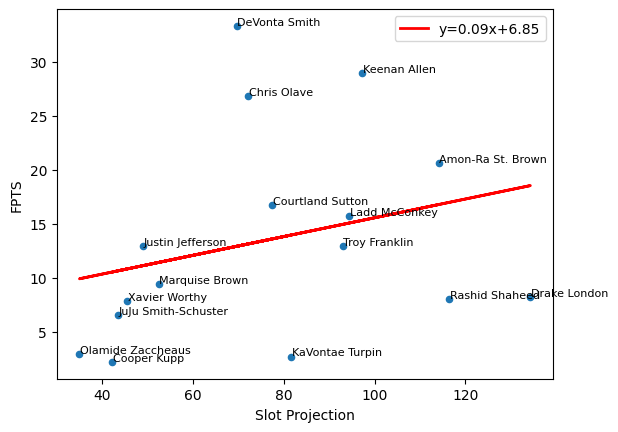

16 Wide Projection correlation: 0.1743

16 Slot Projection correlation: 0.2735



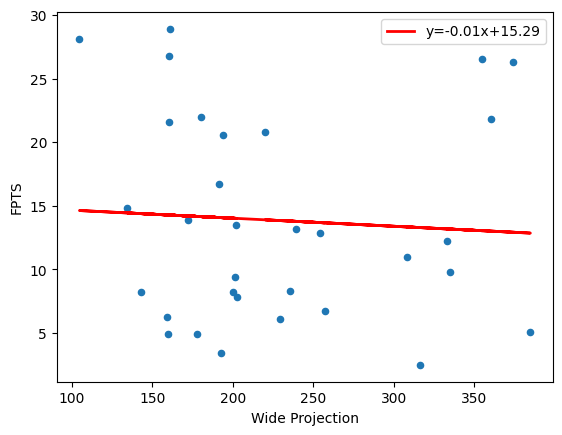

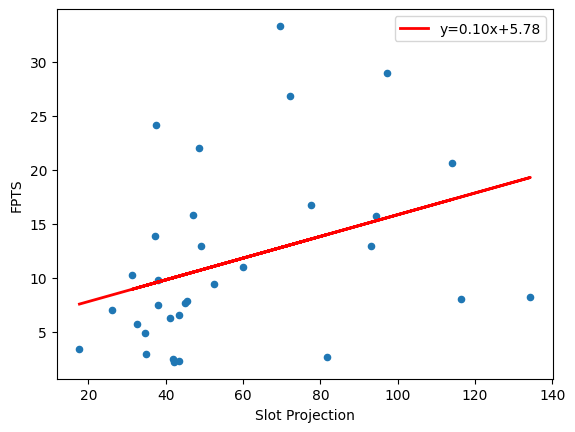

32 Wide Projection correlation: -0.0608

32 Slot Projection correlation: 0.3532



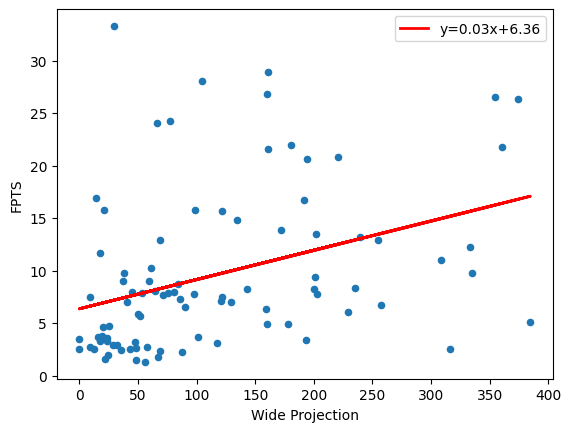

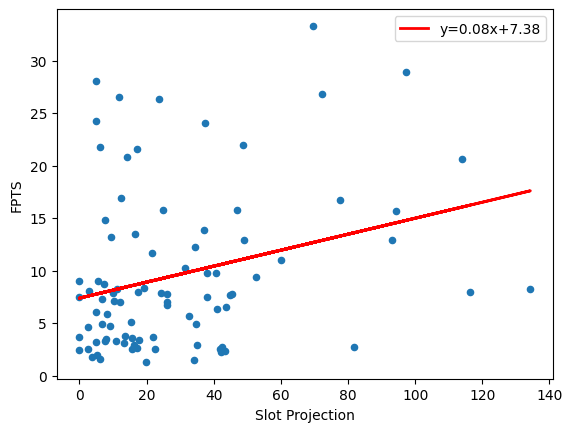

All Wide Projection correlation: 0.3651

All Slot Projection correlation: 0.2851



In [ ]:
# WIDE PROJECTION VS REALITY, SLOT PROJECTION VS REALITY
# DIFF BETWEEN TOP 16, TOP 32, AND ALL

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

wr = pd.read_csv("WR6.csv")
defense = pd.read_csv("Defense6.csv")
defense.rename(columns={"Next Opp": 'Team'}, inplace = True)
wr = wr.merge(defense, how = "inner", on = "Team")
wr = wr.sort_values("Total Points", ascending = False)

results = pd.read_csv("WR6Results.csv")
results.rename(columns = {"NAME": "Player"}, inplace = True)
wr = wr.merge(results, how = "inner", on = "Player")

wr["Slot Projection"] = wr["Slot PPG"] * wr["Slot PPG Allowed"]
wr["Wide Projection"] = wr["Wide PPG"] * wr["Wide PPG Allowed"]
wr["Both Projection"] = wr["Slot Projection"] + wr["Wide Projection"]
wr["Total Projection"] = wr["Total Points"] * wr["Total PPG Allowed"]

# print(wr.to_string())

wr_top16wide = wr.sort_values("Wide PPG", ascending = False).head(16)
wr_top16slot = wr.sort_values("Slot PPG", ascending = False).head(16)

wr_top16wide.plot(kind = "scatter", x = "Wide Projection", y = "FPTS")
b = np.polyfit(wr_top16wide["Wide Projection"], wr_top16wide["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr_top16wide["Wide Projection"], bline(wr_top16wide["Wide Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')
for w, row in wr_top16wide.iterrows():
    plt.text(row["Wide Projection"] + 0.1,
             row["FPTS"] + 0.1,
             row["Player"], fontsize=8)

plt.legend()
plt.show()

wr_top16slot.plot(kind = "scatter", x = "Slot Projection", y = "FPTS")
t = np.polyfit(wr_top16slot["Slot Projection"], wr_top16slot["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr_top16slot["Slot Projection"], tline(wr_top16slot["Slot Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')
for s, row in wr_top16slot.iterrows():
    plt.text(row["Slot Projection"] + 0.1,
             row["FPTS"] + 0.1,
             row["Player"], fontsize=8)

plt.legend()
plt.show()

corr3 = wr_top16wide["Wide Projection"].corr(wr_top16wide["FPTS"])
corr4 = wr_top16slot["Slot Projection"].corr(wr_top16slot["FPTS"])
print(f"16 Wide Projection correlation: {corr3:.4f}\n")
print(f"16 Slot Projection correlation: {corr4:.4f}\n")

wr_top32wide = wr.sort_values("Wide PPG", ascending = False).head(32)
wr_top32slot = wr.sort_values("Slot PPG", ascending = False).head(32)

wr_top32wide.plot(kind = "scatter", x = "Wide Projection", y = "FPTS")
b = np.polyfit(wr_top32wide["Wide Projection"], wr_top32wide["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr_top32wide["Wide Projection"], bline(wr_top32wide["Wide Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')

plt.legend()
plt.show()

wr_top32slot.plot(kind = "scatter", x = "Slot Projection", y = "FPTS")
t = np.polyfit(wr_top32slot["Slot Projection"], wr_top32slot["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr_top32slot["Slot Projection"], tline(wr_top32slot["Slot Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')

plt.legend()
plt.show()

corr5 = wr_top32wide["Wide Projection"].corr(wr_top32wide["FPTS"])
corr6 = wr_top32slot["Slot Projection"].corr(wr_top32slot["FPTS"])
print(f"32 Wide Projection correlation: {corr5:.4f}\n")
print(f"32 Slot Projection correlation: {corr6:.4f}\n")

wr.plot(kind = "scatter", x = "Wide Projection", y = "FPTS")
b = np.polyfit(wr["Wide Projection"], wr["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr["Wide Projection"], bline(wr["Wide Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')

plt.legend()
plt.show()

wr.plot(kind = "scatter", x = "Slot Projection", y = "FPTS")
t = np.polyfit(wr["Slot Projection"], wr["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr["Slot Projection"], tline(wr["Slot Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')

plt.legend()
plt.show()

corr7 = wr["Wide Projection"].corr(wr["FPTS"])
corr8 = wr["Slot Projection"].corr(wr["FPTS"])
print(f"All Wide Projection correlation: {corr7:.4f}\n")
print(f"All Slot Projection correlation: {corr8:.4f}\n")


In [ ]:
print(f"Both Projection correlation: {corr1:.4f}\n")
print(f"Total Projection correlation: {corr2:.4f}\n")
print(f"16 Wide Projection correlation: {corr3:.4f}\n")
print(f"16 Slot Projection correlation: {corr4:.4f}\n")
print(f"32 Wide Projection correlation: {corr5:.4f}\n")
print(f"32 Slot Projection correlation: {corr6:.4f}\n")
print(f"All Wide Projection correlation: {corr7:.4f}\n")
print(f"All Slot Projection correlation: {corr8:.4f}\n")

Both Projection correlation: 0.4166

Total Projection correlation: 0.4359

16 Wide Projection correlation: 0.1743

16 Slot Projection correlation: 0.2735

32 Wide Projection correlation: -0.0608

32 Slot Projection correlation: 0.3532

All Wide Projection correlation: 0.3651

All Slot Projection correlation: 0.2851



# Week 8 Projections

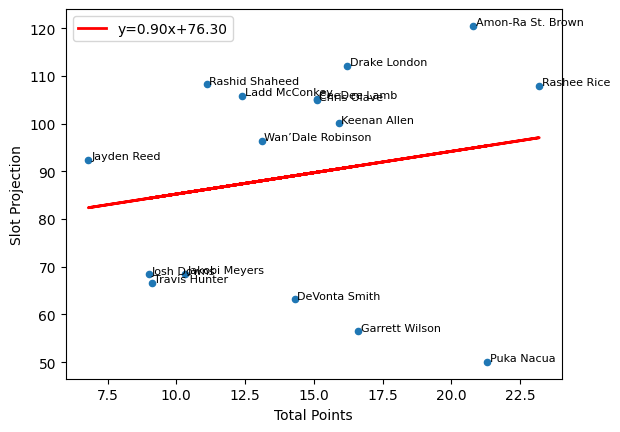

Players expected to have more than average Slot points (consider starting): 
Amon-Ra St. Brown
  PPG: 20.80
  Slot Projection: 120.52 (Expected: 94.93)
Rashee Rice
  PPG: 23.20
  Slot Projection: 107.91 (Expected: 97.08)
Wan’Dale Robinson
  PPG: 13.10
  Slot Projection: 96.46 (Expected: 88.03)
Ladd McConkey
  PPG: 12.40
  Slot Projection: 105.82 (Expected: 87.41)
Keenan Allen
  PPG: 15.90
  Slot Projection: 100.10 (Expected: 90.54)
Jayden Reed
  PPG: 6.80
  Slot Projection: 92.48 (Expected: 82.39)
CeeDee Lamb
  PPG: 15.10
  Slot Projection: 105.19 (Expected: 89.83)
Drake London
  PPG: 16.20
  Slot Projection: 112.20 (Expected: 90.81)
Rashid Shaheed
  PPG: 11.10
  Slot Projection: 108.24 (Expected: 86.24)
Chris Olave
  PPG: 15.10
  Slot Projection: 104.96 (Expected: 89.83)

Players expected to have less than average Slot points - averaging less than 15 points a game - (consider benching): 
DeVonta Smith
  PPG: 14.30
  Slot Projection: 63.18 (Expected: 89.11)
Josh Downs
  PPG: 9.00
  Slo

In [ ]:
# MAKING SLOT AND WIDE PROJECTION BASED ON MATCHUP AND PREVIOUS GAMES

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

wr = pd.read_csv("WR7.csv")
defense = pd.read_csv("Defense7.csv")
defense.rename(columns={'Next Opp': 'Team'}, inplace = True)
wr = wr.merge(defense, how = 'inner', on = 'Team')
wr = wr.sort_values('Total Points', ascending = False)

wr["Slot Projection"] = wr["Slot PPG"] * wr["Slot PPG Allowed"]
# wr = wr.sort_values("Slot Projection", ascending=False)
# wr.nlargest(10, "Slot Projection")

wr["Wide Projection"] = wr["Wide PPG"] * wr["Wide PPG Allowed"]
# wr = wr.sort_values("Wide Projection", ascending=False)
# wr.nlargest(10, "Wide Projection")

wr["Total Projection"] = wr["Total Points"] * wr["Total PPG Allowed"]
# wr = wr.sort_values("Total Projection", ascending=False)
# wr.nlargest(10, "Total Projection")

#print(wr.to_string())

wr_slot = wr.sort_values("Slot PPG", ascending = False)
wr_slot16 = wr_slot.head(16)
wr_slot32 = wr_slot.head(32)

wr_wide = wr.sort_values("Wide PPG", ascending = False)
wr_wide16 = wr_wide.head(16)
wr_wide32 = wr_wide.head(32)

#below is changeable

wr_slot16.plot(kind = "scatter", x = "Total Points", y = "Slot Projection")
t = np.polyfit(wr_slot16["Total Points"], wr_slot16["Slot Projection"], 1)
tline = np.poly1d(t)
plt.plot(wr_slot16["Total Points"], tline(wr_slot16["Total Points"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')
for s, row in wr_slot16.iterrows():
    plt.text(row["Total Points"] + 0.1,
             row["Slot Projection"] + 0.1,
             row["Player"], fontsize=8)


plt.legend()
plt.show()


# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]


print("Players expected to have more than average Slot points (consider starting): ")
for i, row in wr_slot16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")


print("\nPlayers expected to have less than average Slot points - averaging less than 15 points a game - (consider benching): ")
for i, row in wr_slot16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] < expected and row["Total Points"] < 15:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")




# Week 8 Result Comparison

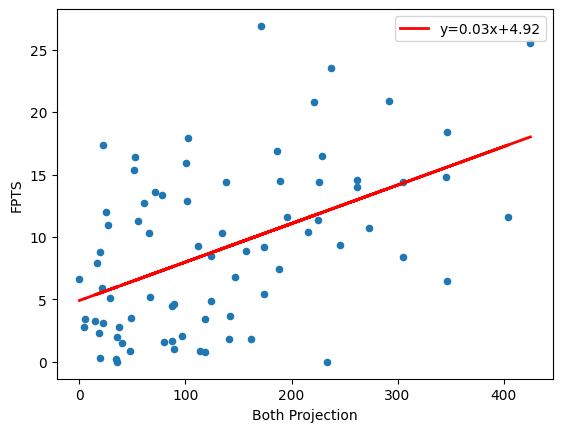

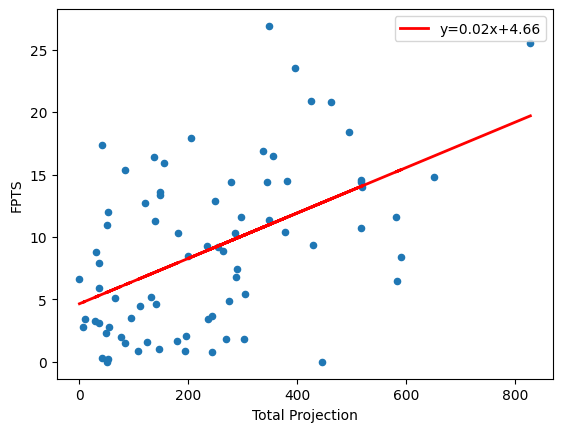

Both Projection correlation: 0.4898

Total Projection correlation: 0.5009



In [ ]:
# ADD WIDE VS SLOT PROJECTION COMPARED TO OVERALL PROJECTION, COMPARING BOTH TO FPTS

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

wr = pd.read_csv("WR7.csv")
defense = pd.read_csv("Defense7.csv")
defense.rename(columns={"Next Opp": 'Team'}, inplace = True)
wr = wr.merge(defense, how = "inner", on = "Team")
wr = wr.sort_values("Total Points", ascending = False)

results = pd.read_csv("WR7Results.csv")
results.rename(columns = {"NAME": "Player"}, inplace = True)
wr = wr.merge(results, how = "inner", on = "Player")

wr["Slot Projection"] = wr["Slot PPG"] * wr["Slot PPG Allowed"]
wr["Wide Projection"] = wr["Wide PPG"] * wr["Wide PPG Allowed"]
wr["Both Projection"] = wr["Slot Projection"] + wr["Wide Projection"]
wr["Total Projection"] = wr["Total Points"] * wr["Total PPG Allowed"]

# print(wr.to_string())

wr.plot(kind = "scatter", x = "Both Projection", y = "FPTS")
b = np.polyfit(wr["Both Projection"], wr["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr["Both Projection"], bline(wr["Both Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')
plt.legend()
plt.show()

wr.plot(kind = "scatter", x = "Total Projection", y = "FPTS")
t = np.polyfit(wr["Total Projection"], wr["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr["Total Projection"], tline(wr["Total Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')
plt.legend()
plt.show()

corr1 = wr["Both Projection"].corr(wr["FPTS"])
corr2 = wr["Total Projection"].corr(wr["FPTS"])
print(f"Both Projection correlation: {corr1:.4f}\n")
print(f"Total Projection correlation: {corr2:.4f}\n")


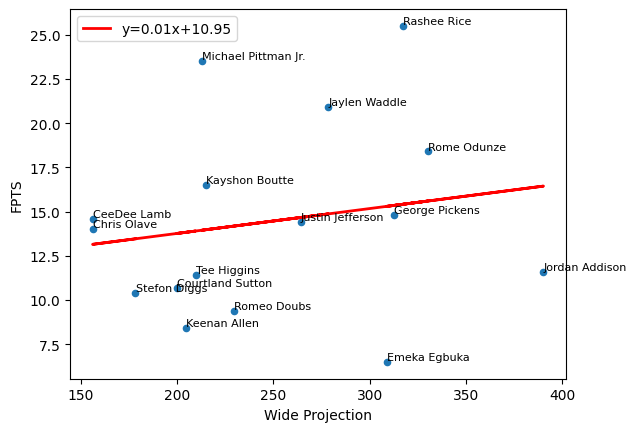

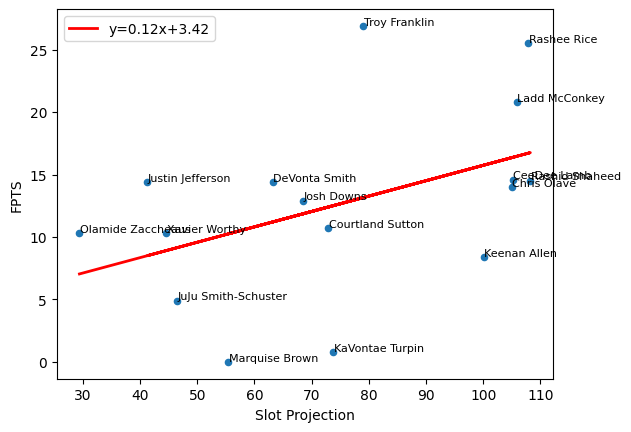

16 Wide Projection correlation: 0.1787

16 Slot Projection correlation: 0.4473



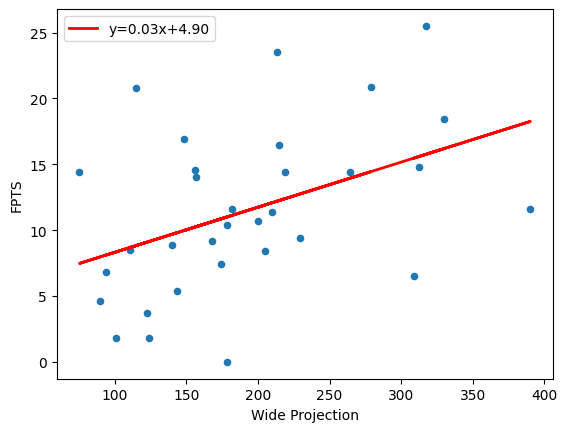

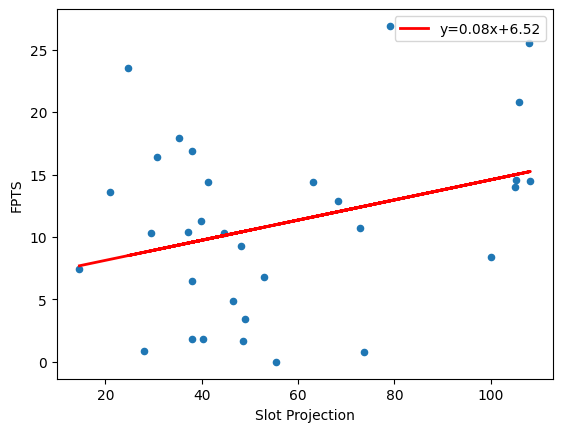

32 Wide Projection correlation: 0.4284

32 Slot Projection correlation: 0.3148



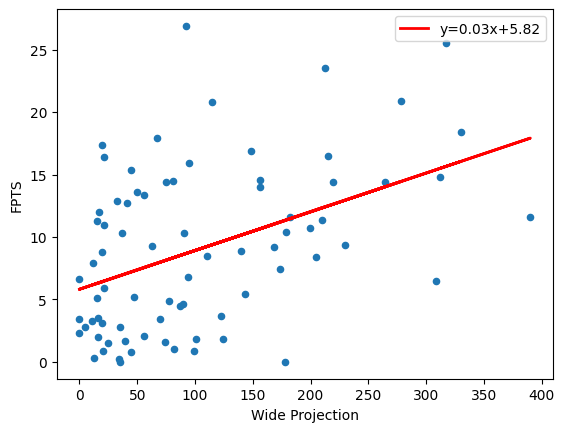

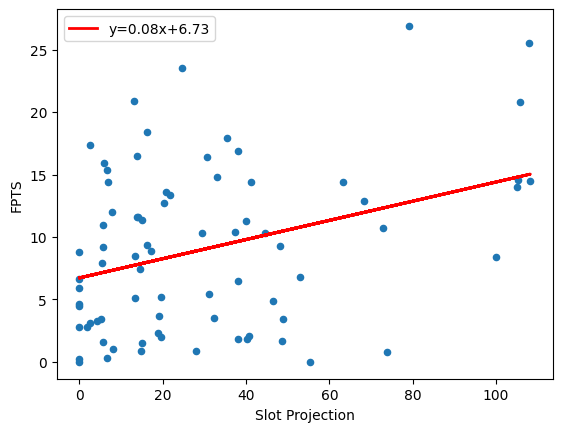

All Wide Projection correlation: 0.4398

All Slot Projection correlation: 0.3450



In [ ]:
# WIDE PROJECTION VS REALITY, SLOT PROJECTION VS REALITY
# DIFF BETWEEN TOP 16, TOP 32, AND ALL

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

wr = pd.read_csv("WR7.csv")
defense = pd.read_csv("Defense7.csv")
defense.rename(columns={"Next Opp": 'Team'}, inplace = True)
wr = wr.merge(defense, how = "inner", on = "Team")
wr = wr.sort_values("Total Points", ascending = False)

results = pd.read_csv("WR7Results.csv")
results.rename(columns = {"NAME": "Player"}, inplace = True)
wr = wr.merge(results, how = "inner", on = "Player")

wr["Slot Projection"] = wr["Slot PPG"] * wr["Slot PPG Allowed"]
wr["Wide Projection"] = wr["Wide PPG"] * wr["Wide PPG Allowed"]
wr["Both Projection"] = wr["Slot Projection"] + wr["Wide Projection"]
wr["Total Projection"] = wr["Total Points"] * wr["Total PPG Allowed"]

# print(wr.to_string())

wr_top16wide = wr.sort_values("Wide PPG", ascending = False).head(16)
wr_top16slot = wr.sort_values("Slot PPG", ascending = False).head(16)

wr_top16wide.plot(kind = "scatter", x = "Wide Projection", y = "FPTS")
b = np.polyfit(wr_top16wide["Wide Projection"], wr_top16wide["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr_top16wide["Wide Projection"], bline(wr_top16wide["Wide Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')
for w, row in wr_top16wide.iterrows():
    plt.text(row["Wide Projection"] + 0.1,
             row["FPTS"] + 0.1,
             row["Player"], fontsize=8)

plt.legend()
plt.show()

wr_top16slot.plot(kind = "scatter", x = "Slot Projection", y = "FPTS")
t = np.polyfit(wr_top16slot["Slot Projection"], wr_top16slot["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr_top16slot["Slot Projection"], tline(wr_top16slot["Slot Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')
for s, row in wr_top16slot.iterrows():
    plt.text(row["Slot Projection"] + 0.1,
             row["FPTS"] + 0.1,
             row["Player"], fontsize=8)

plt.legend()
plt.show()

corr1 = wr_top16wide["Wide Projection"].corr(wr_top16wide["FPTS"])
corr2 = wr_top16slot["Slot Projection"].corr(wr_top16slot["FPTS"])
print(f"16 Wide Projection correlation: {corr1:.4f}\n")
print(f"16 Slot Projection correlation: {corr2:.4f}\n")

wr_top32wide = wr.sort_values("Wide PPG", ascending = False).head(32)
wr_top32slot = wr.sort_values("Slot PPG", ascending = False).head(32)

wr_top32wide.plot(kind = "scatter", x = "Wide Projection", y = "FPTS")
b = np.polyfit(wr_top32wide["Wide Projection"], wr_top32wide["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr_top32wide["Wide Projection"], bline(wr_top32wide["Wide Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')
plt.legend()
plt.show()

wr_top32slot.plot(kind = "scatter", x = "Slot Projection", y = "FPTS")
t = np.polyfit(wr_top32slot["Slot Projection"], wr_top32slot["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr_top32slot["Slot Projection"], tline(wr_top32slot["Slot Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')
plt.legend()
plt.show()

corr1 = wr_top32wide["Wide Projection"].corr(wr_top32wide["FPTS"])
corr2 = wr_top32slot["Slot Projection"].corr(wr_top32slot["FPTS"])
print(f"32 Wide Projection correlation: {corr1:.4f}\n")
print(f"32 Slot Projection correlation: {corr2:.4f}\n")

wr.plot(kind = "scatter", x = "Wide Projection", y = "FPTS")
b = np.polyfit(wr["Wide Projection"], wr["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr["Wide Projection"], bline(wr["Wide Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')
plt.legend()
plt.show()

wr.plot(kind = "scatter", x = "Slot Projection", y = "FPTS")
t = np.polyfit(wr["Slot Projection"], wr["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr["Slot Projection"], tline(wr["Slot Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')
plt.legend()
plt.show()

corr1 = wr["Wide Projection"].corr(wr["FPTS"])
corr2 = wr["Slot Projection"].corr(wr["FPTS"])
print(f"All Wide Projection correlation: {corr1:.4f}\n")
print(f"All Slot Projection correlation: {corr2:.4f}\n")


# Week 9 Projections

     #_x                    Player Pos Team  Games  Total Points  Slot PPG Slot%_x  Wide PPG Wide%_x  #_y Defense  Total PPG Allowed  Slot PPG Allowed  Wide PPG Allowed Slot%_y Wide%_y  Slot Projection  Wide Projection  Total Projection
0      1               Rashee Rice  WR   KC      2          23.8      10.2     43%      13.6     57%    4     BUF               25.0               8.0              17.0     33%     67%            81.60           231.20            595.00
1      2        Jaxon Smith-Njigba  WR  SEA      7          22.3       2.7     12%      19.5     88%   32     WAS               41.6              18.9              22.7     50%     50%            51.03           442.65            927.68
2      3             Ja’Marr Chase  WR  CIN      8          21.5       6.3     29%      15.2     71%    6     CHI               29.4              12.9              16.5     38%     47%            81.27           250.80            632.10
3      4                Puka Nacua  WR   LA      6  

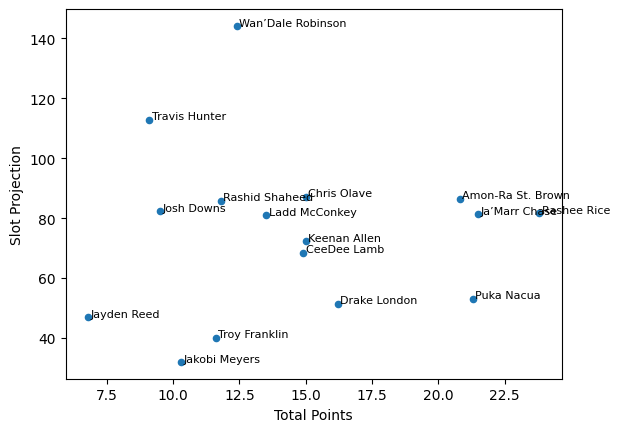

In [ ]:
# MAKING SLOT AND WIDE PROJECTION BASED ON MATCHUP AND PREVIOUS GAMES

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

wr = pd.read_csv("WR8.csv")
defense = pd.read_csv("Defense8.csv")
defense.rename(columns={'Next Opp': 'Team'}, inplace = True)
wr = wr.merge(defense, how = 'inner', on = 'Team')
wr = wr.sort_values('Total Points', ascending = False)

wr["Slot Projection"] = wr["Slot PPG"] * wr["Slot PPG Allowed"]
# wr = wr.sort_values("Slot Projection", ascending=False)
# wr.nlargest(10, "Slot Projection")

wr["Wide Projection"] = wr["Wide PPG"] * wr["Wide PPG Allowed"]
# wr = wr.sort_values("Wide Projection", ascending=False)
# wr.nlargest(10, "Wide Projection")

wr["Total Projection"] = wr["Total Points"] * wr["Total PPG Allowed"]
# wr = wr.sort_values("Total Projection", ascending=False)
# wr.nlargest(10, "Total Projection")

print(wr.to_string())

wr_slot = wr.sort_values("Slot PPG", ascending = False)
wr_slot16 = wr_slot.head(16)
wr_slot32 = wr_slot.head(32)

wr_wide = wr.sort_values("Wide PPG", ascending = False)
wr_wide16 = wr_wide.head(16)
wr_wide32 = wr_wide.head(32)

#below is changeable

wr_slot16.plot(kind = "scatter", x = "Total Points", y = "Slot Projection")
t = np.polyfit(wr_slot16["Total Points"], wr_slot16["Slot Projection"], 1)
for s, row in wr_slot16.iterrows():
    plt.text(row["Total Points"] + 0.1,
             row["Slot Projection"] + 0.1,
             row["Player"], fontsize=8)


# plt.show()


# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]


print("Players expected to have more than average Slot points (consider starting): ")
for i, row in wr_slot16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")


print("\nPlayers expected to have less than average Slot points - averaging less than 15 points a game - (consider benching): ")
for i, row in wr_slot16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] < expected and row["Total Points"] < 15:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")




# Week 9 Result Comparison

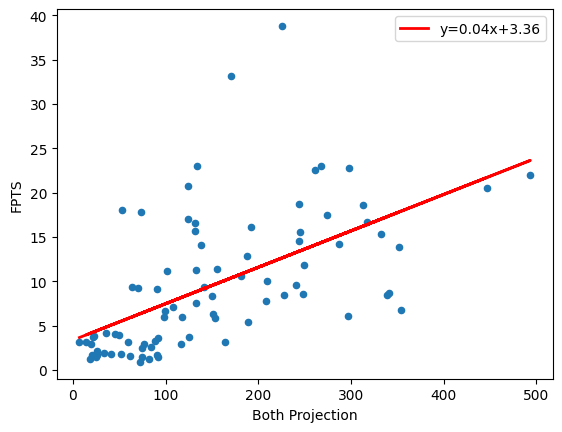

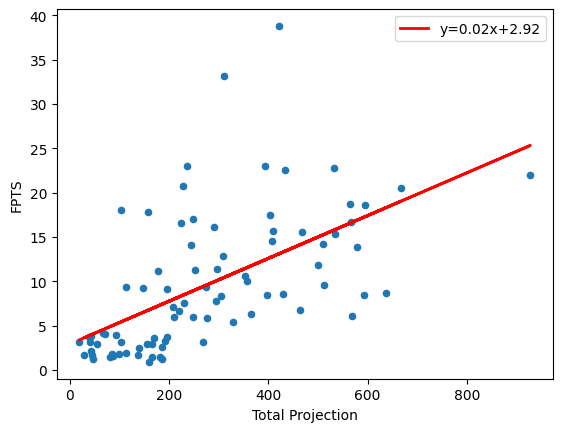

Both Projection correlation: 0.5758

Total Projection correlation: 0.5809



In [ ]:
# ADD WIDE VS SLOT PROJECTION COMPARED TO OVERALL PROJECTION, COMPARING BOTH TO FPTS

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

wr = pd.read_csv("WR8.csv")
defense = pd.read_csv("Defense8.csv")
defense.rename(columns={"Next Opp": 'Team'}, inplace = True)
wr = wr.merge(defense, how = "inner", on = "Team")
wr = wr.sort_values("Total Points", ascending = False)

results = pd.read_csv("WR8Results.csv")
results.rename(columns = {"NAME": "Player"}, inplace = True)
wr = wr.merge(results, how = "inner", on = "Player")

wr["Slot Projection"] = wr["Slot PPG"] * wr["Slot PPG Allowed"]
wr["Wide Projection"] = wr["Wide PPG"] * wr["Wide PPG Allowed"]
wr["Both Projection"] = wr["Slot Projection"] + wr["Wide Projection"]
wr["Total Projection"] = wr["Total Points"] * wr["Total PPG Allowed"]

# print(wr.to_string())

wr.plot(kind = "scatter", x = "Both Projection", y = "FPTS")
b = np.polyfit(wr["Both Projection"], wr["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr["Both Projection"], bline(wr["Both Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')
plt.legend()
plt.show()

wr.plot(kind = "scatter", x = "Total Projection", y = "FPTS")
t = np.polyfit(wr["Total Projection"], wr["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr["Total Projection"], tline(wr["Total Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')
plt.legend()
plt.show()

corr1 = wr["Both Projection"].corr(wr["FPTS"])
corr2 = wr["Total Projection"].corr(wr["FPTS"])
print(f"Both Projection correlation: {corr1:.4f}\n")
print(f"Total Projection correlation: {corr2:.4f}\n")


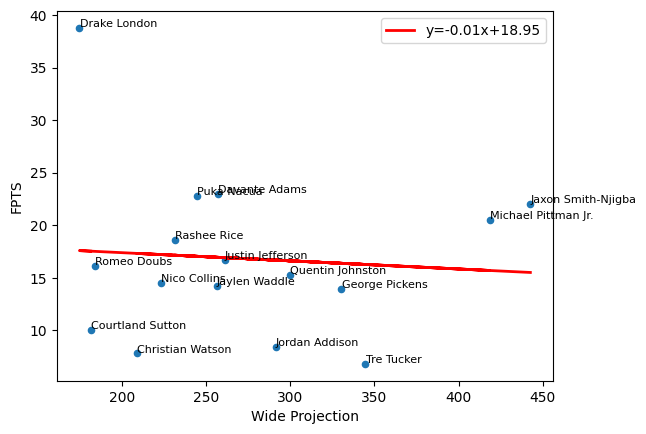

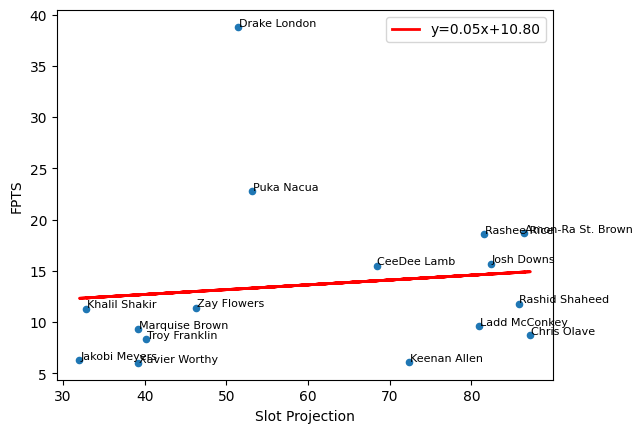

16 Wide Projection correlation: -0.0789

16 Slot Projection correlation: 0.1199



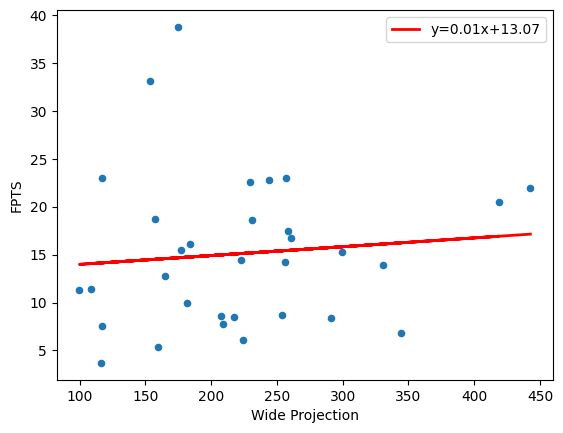

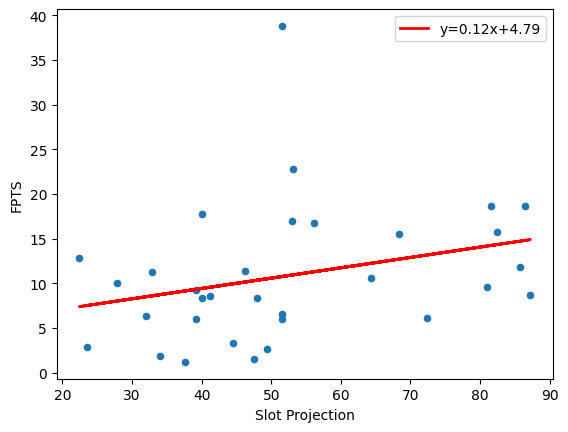

32 Wide Projection correlation: 0.0970

32 Slot Projection correlation: 0.2924



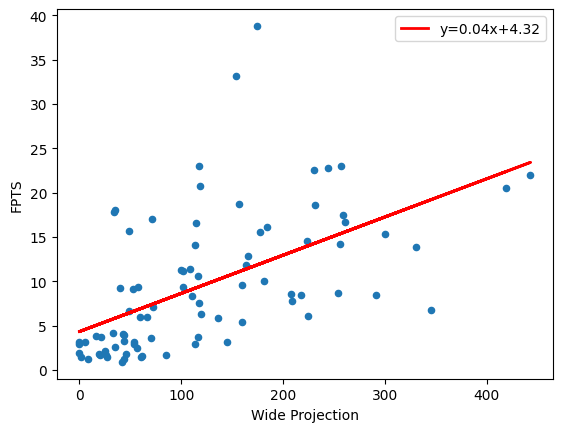

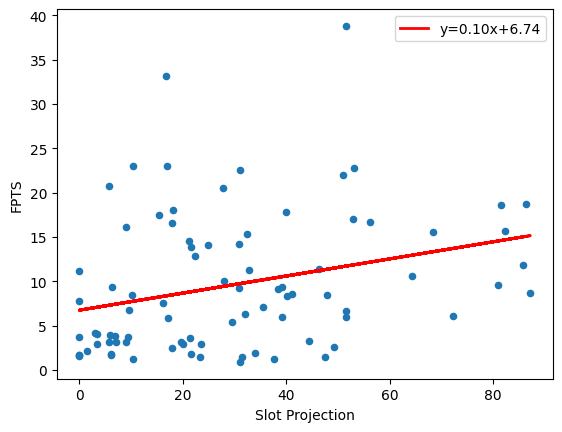

All Wide Projection correlation: 0.5567

All Slot Projection correlation: 0.2917



In [ ]:
# WIDE PROJECTION VS REALITY, SLOT PROJECTION VS REALITY
# DIFF BETWEEN TOP 16, TOP 32, AND ALL

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

wr = pd.read_csv("WR8.csv")
defense = pd.read_csv("Defense8.csv")
defense.rename(columns={"Next Opp": 'Team'}, inplace = True)
wr = wr.merge(defense, how = "inner", on = "Team")
wr = wr.sort_values("Total Points", ascending = False)

results = pd.read_csv("WR8Results.csv")
results.rename(columns = {"NAME": "Player"}, inplace = True)
wr = wr.merge(results, how = "inner", on = "Player")

wr["Slot Projection"] = wr["Slot PPG"] * wr["Slot PPG Allowed"]
wr["Wide Projection"] = wr["Wide PPG"] * wr["Wide PPG Allowed"]
wr["Both Projection"] = wr["Slot Projection"] + wr["Wide Projection"]
wr["Total Projection"] = wr["Total Points"] * wr["Total PPG Allowed"]

# print(wr.to_string())

wr_top16wide = wr.sort_values("Wide PPG", ascending = False).head(16)
wr_top16slot = wr.sort_values("Slot PPG", ascending = False).head(16)

wr_top16wide.plot(kind = "scatter", x = "Wide Projection", y = "FPTS")
b = np.polyfit(wr_top16wide["Wide Projection"], wr_top16wide["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr_top16wide["Wide Projection"], bline(wr_top16wide["Wide Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')
for w, row in wr_top16wide.iterrows():
    plt.text(row["Wide Projection"] + 0.1,
             row["FPTS"] + 0.1,
             row["Player"], fontsize=8)

plt.legend()
plt.show()

wr_top16slot.plot(kind = "scatter", x = "Slot Projection", y = "FPTS")
t = np.polyfit(wr_top16slot["Slot Projection"], wr_top16slot["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr_top16slot["Slot Projection"], tline(wr_top16slot["Slot Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')
for s, row in wr_top16slot.iterrows():
    plt.text(row["Slot Projection"] + 0.1,
             row["FPTS"] + 0.1,
             row["Player"], fontsize=8)

plt.legend()
plt.show()

corr1 = wr_top16wide["Wide Projection"].corr(wr_top16wide["FPTS"])
corr2 = wr_top16slot["Slot Projection"].corr(wr_top16slot["FPTS"])
print(f"16 Wide Projection correlation: {corr1:.4f}\n")
print(f"16 Slot Projection correlation: {corr2:.4f}\n")

wr_top32wide = wr.sort_values("Wide PPG", ascending = False).head(32)
wr_top32slot = wr.sort_values("Slot PPG", ascending = False).head(32)

wr_top32wide.plot(kind = "scatter", x = "Wide Projection", y = "FPTS")
b = np.polyfit(wr_top32wide["Wide Projection"], wr_top32wide["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr_top32wide["Wide Projection"], bline(wr_top32wide["Wide Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')
plt.legend()
plt.show()

wr_top32slot.plot(kind = "scatter", x = "Slot Projection", y = "FPTS")
t = np.polyfit(wr_top32slot["Slot Projection"], wr_top32slot["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr_top32slot["Slot Projection"], tline(wr_top32slot["Slot Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')
plt.legend()
plt.show()

corr1 = wr_top32wide["Wide Projection"].corr(wr_top32wide["FPTS"])
corr2 = wr_top32slot["Slot Projection"].corr(wr_top32slot["FPTS"])
print(f"32 Wide Projection correlation: {corr1:.4f}\n")
print(f"32 Slot Projection correlation: {corr2:.4f}\n")

wr.plot(kind = "scatter", x = "Wide Projection", y = "FPTS")
b = np.polyfit(wr["Wide Projection"], wr["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr["Wide Projection"], bline(wr["Wide Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')
plt.legend()
plt.show()

wr.plot(kind = "scatter", x = "Slot Projection", y = "FPTS")
t = np.polyfit(wr["Slot Projection"], wr["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr["Slot Projection"], tline(wr["Slot Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')
plt.legend()
plt.show()

corr1 = wr["Wide Projection"].corr(wr["FPTS"])
corr2 = wr["Slot Projection"].corr(wr["FPTS"])
print(f"All Wide Projection correlation: {corr1:.4f}\n")
print(f"All Slot Projection correlation: {corr2:.4f}\n")


# Week 10 Projections

Top 64: Players expected to have more than average Total points (consider starting): 
Puka Nacua
  PPG: 21.40
  Total Projection: 763.98 (Expected: 703.21)
  Diff: 60.77
Amon-Ra St. Brown
  PPG: 20.60
  Total Projection: 815.76 (Expected: 676.54)
  Diff: 139.22
Drake London
  PPG: 19.40
  Total Projection: 754.66 (Expected: 636.53)
  Diff: 118.13
Davante Adams
  PPG: 16.60
  Total Projection: 592.62 (Expected: 543.18)
  Diff: 49.44
Garrett Wilson
  PPG: 16.60
  Total Projection: 557.76 (Expected: 543.18)
  Diff: 14.58
Justin Jefferson
  PPG: 15.50
  Total Projection: 598.30 (Expected: 506.51)
  Diff: 91.79
Quentin Johnston
  PPG: 14.30
  Total Projection: 643.50 (Expected: 466.50)
  Diff: 177.00
Jordan Addison
  PPG: 14.10
  Total Projection: 544.26 (Expected: 459.83)
  Diff: 84.43
Keenan Allen
  PPG: 14.00
  Total Projection: 630.00 (Expected: 456.50)
  Diff: 173.50
Courtland Sutton
  PPG: 13.20
  Total Projection: 496.32 (Expected: 429.83)
  Diff: 66.49
Ricky Pearsall
  PPG: 13.20
  

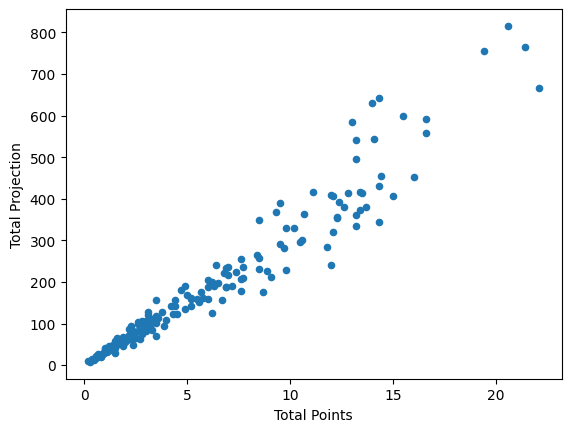

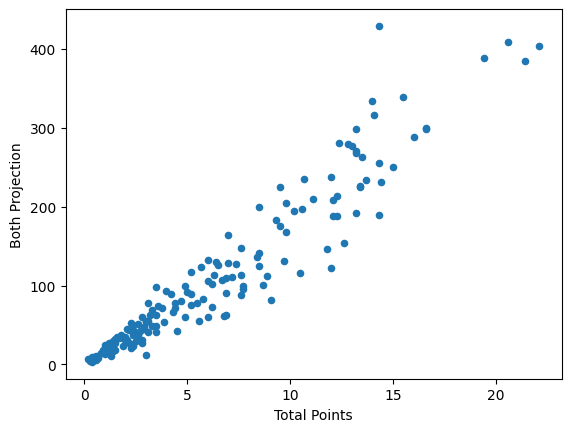

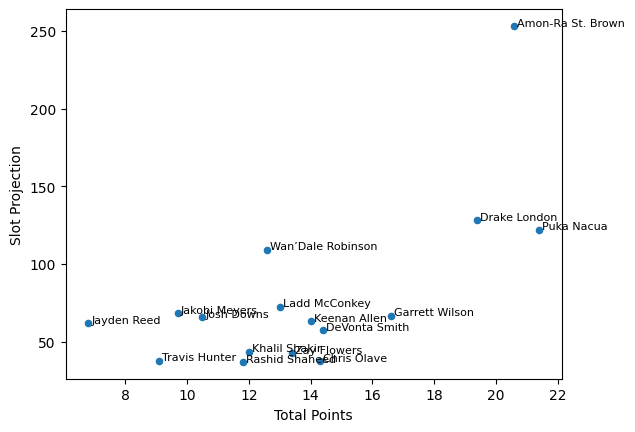

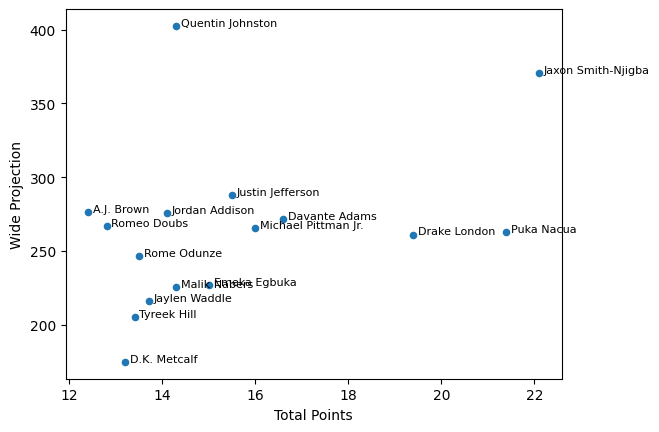

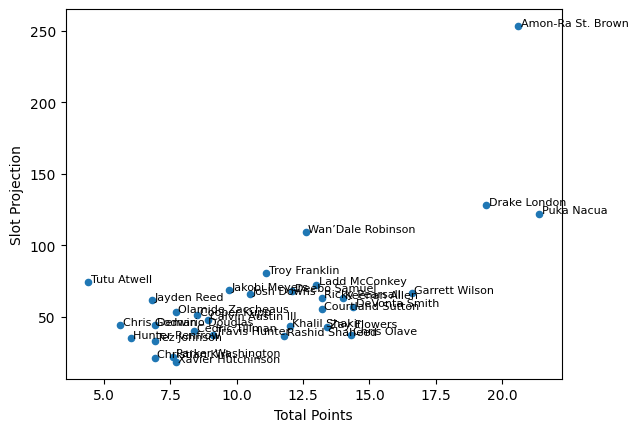

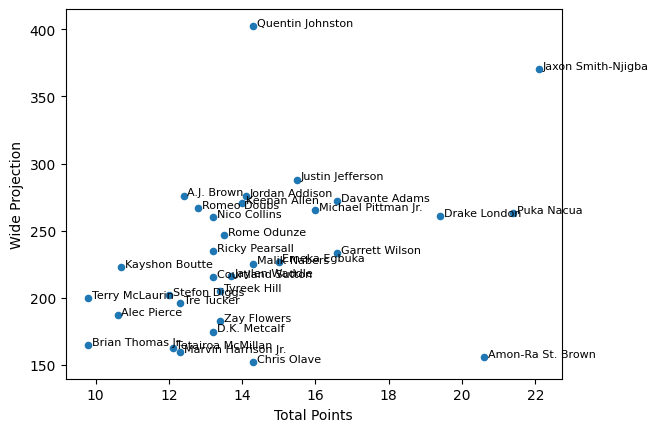

In [ ]:
# MAKING SLOT AND WIDE PROJECTION BASED ON MATCHUP AND PREVIOUS GAMES

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

wr = pd.read_csv("WR9.csv")
defense = pd.read_csv("Defense9.csv")
defense.rename(columns={'Next Opp': 'Team'}, inplace = True)
wr = wr.merge(defense, how = 'inner', on = 'Team')
wr = wr.sort_values('Total Points', ascending = False)

wr["Slot Projection"] = wr["Slot PPG"] * wr["Slot PPG Allowed"]
# wr = wr.sort_values("Slot Projection", ascending=False)
# wr.nlargest(10, "Slot Projection")

wr["Wide Projection"] = wr["Wide PPG"] * wr["Wide PPG Allowed"]
# wr = wr.sort_values("Wide Projection", ascending=False)
# wr.nlargest(10, "Wide Projection")

wr["Total Projection"] = wr["Total Points"] * wr["Total PPG Allowed"]
# wr = wr.sort_values("Total Projection", ascending=False)
# wr.nlargest(10, "Total Projection")

wr["Both Projection"] = wr["Slot Projection"] + wr["Wide Projection"]
# wr = wr.sort_values("Both Projection", ascending=False)
# wr.nlargest(10, "Both Projection")


# print(wr.to_string())

wr_slot = wr.sort_values("Slot PPG", ascending = False)
wr_slot16 = wr_slot.head(16)
wr_slot32 = wr_slot.head(32)

wr_wide = wr.sort_values("Wide PPG", ascending = False)
wr_wide16 = wr_wide.head(16)
wr_wide32 = wr_wide.head(32)


#below is changeable


wr.plot(kind = "scatter", x = "Total Points", y = "Total Projection")
t = np.polyfit(wr["Total Points"], wr["Total Projection"], 1)


# plt.show()


# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]


print("Top 64: Players expected to have more than average Total points (consider starting): ")
for i, row in (wr.head(64)).iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Total Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Total Projection: {row['Total Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Total Projection'] - expected
        print(f"  Diff: {diff:.2f}")


#below is changeable


wr.plot(kind = "scatter", x = "Total Points", y = "Both Projection")
t = np.polyfit(wr["Total Points"], wr["Both Projection"], 1)


# plt.show()


# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]




print("\n\n\nTop 64: Players expected to have more than average Both points (consider starting): ")
for i, row in (wr.head(64)).iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Both Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Both Projection: {row['Both Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Both Projection'] - expected
        print(f"  Diff: {diff:.2f}")



#below is changeable

wr_slot16.plot(kind = "scatter", x = "Total Points", y = "Slot Projection")
t = np.polyfit(wr_slot16["Total Points"], wr_slot16["Slot Projection"], 1)
for s, row in wr_slot16.iterrows():
    plt.text(row["Total Points"] + 0.1,
             row["Slot Projection"] + 0.1,
             row["Player"], fontsize=8)


# plt.show()


# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]


print("\n\n\n16 model: Players expected to have more than average Slot points (consider starting): ")
for i, row in wr_slot16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Slot Projection'] - expected
        print(f"  Diff: {diff:.2f}")


print("\n16 model: Players expected to have less than average Slot points - averaging less than 15 points a game - (consider benching): ")
for i, row in wr_slot16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] < expected and row["Total Points"] < 15:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Slot Projection'] - expected
        print(f"  Diff: {diff:.2f}")


#below is changeable


wr_wide16.plot(kind = "scatter", x = "Total Points", y = "Wide Projection")
t = np.polyfit(wr_wide16["Total Points"], wr_wide16["Wide Projection"], 1)
for s, row in wr_wide16.iterrows():
    plt.text(row["Total Points"] + 0.1,
             row["Wide Projection"] + 0.1,
             row["Player"], fontsize=8)




# plt.show()




# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]




print("\n\n\n16 model: Players expected to have more than average Wide points (consider starting): ")
for i, row in wr_wide16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Wide Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Wide Projection: {row['Wide Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Wide Projection'] - expected
        print(f"  Diff: {diff:.2f}")




print("\n16 model: Players expected to have less than average Wide points - averaging less than 15 points a game - (consider benching): ")
for i, row in wr_wide16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Wide Projection"] < expected and row["Total Points"] < 15:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Wide Projection: {row['Wide Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Wide Projection'] - expected
        print(f"  Diff: {diff:.2f}")


#below is changeable


wr_slot32.plot(kind = "scatter", x = "Total Points", y = "Slot Projection")
t = np.polyfit(wr_slot32["Total Points"], wr_slot32["Slot Projection"], 1)
for s, row in wr_slot32.iterrows():
    plt.text(row["Total Points"] + 0.1,
             row["Slot Projection"] + 0.1,
             row["Player"], fontsize=8)




# plt.show()




# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]




print("\n\n\n32 Model: Players expected to have more than average Slot points (consider starting): ")
for i, row in wr_slot32.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Slot Projection'] - expected
        print(f"  Diff: {diff:.2f}")




print("\n32 Model: Players expected to have less than average Slot points - averaging less than 15 points a game - (consider benching): ")
for i, row in wr_slot32.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] < expected and row["Total Points"] < 15:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Slot Projection'] - expected
        print(f"  Diff: {diff:.2f}")



#below is changeable


wr_wide32.plot(kind = "scatter", x = "Total Points", y = "Wide Projection")
t = np.polyfit(wr_wide32["Total Points"], wr_wide32["Wide Projection"], 1)
for s, row in wr_wide32.iterrows():
    plt.text(row["Total Points"] + 0.1,
             row["Wide Projection"] + 0.1,
             row["Player"], fontsize=8)




# plt.show()




# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]



print("\n\n\n32 Model: Players expected to have more than average Wide points (consider starting): ")
for i, row in wr_wide32.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Wide Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Wide Projection: {row['Wide Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Wide Projection'] - expected
        print(f"  Diff: {diff:.2f}")



print("\n32 Model: Players expected to have less than average Wide points - averaging less than 15 points a game - (consider benching): ")
for i, row in wr_wide32.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Wide Projection"] < expected and row["Total Points"] < 15:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Wide Projection: {row['Wide Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Wide Projection'] - expected
        print(f"  Diff: {diff:.2f}")


# Week 10 Result Comparison

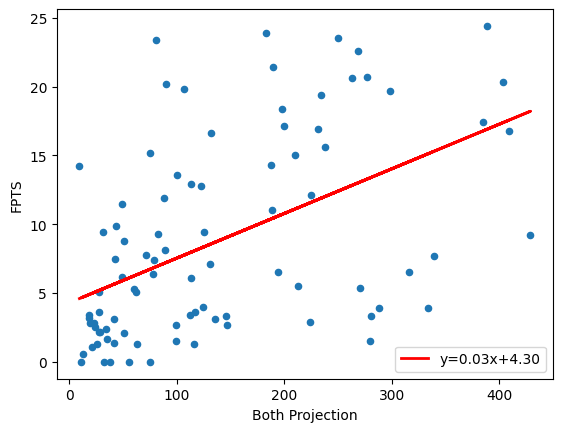

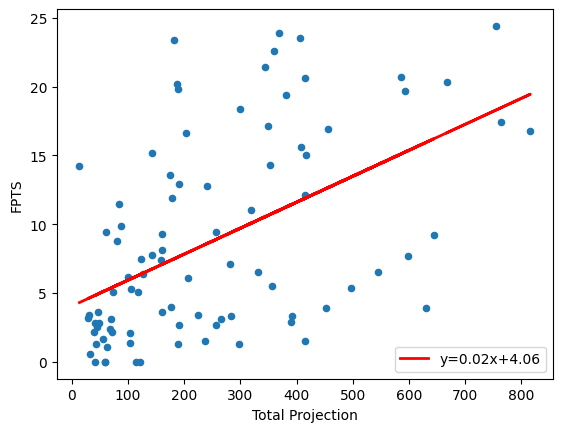

Both Projection correlation: 0.4999

Total Projection correlation: 0.5109



In [ ]:
# ADD WIDE VS SLOT PROJECTION COMPARED TO OVERALL PROJECTION, COMPARING BOTH TO FPTS

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

wr = pd.read_csv("WR9.csv")
defense = pd.read_csv("Defense9.csv")
defense.rename(columns={"Next Opp": 'Team'}, inplace = True)
wr = wr.merge(defense, how = "inner", on = "Team")
wr = wr.sort_values("Total Points", ascending = False)

results = pd.read_csv("WR9Results.csv")
results.rename(columns = {"NAME": "Player"}, inplace = True)
wr = wr.merge(results, how = "inner", on = "Player")

wr["Slot Projection"] = wr["Slot PPG"] * wr["Slot PPG Allowed"]
wr["Wide Projection"] = wr["Wide PPG"] * wr["Wide PPG Allowed"]
wr["Both Projection"] = wr["Slot Projection"] + wr["Wide Projection"]
wr["Total Projection"] = wr["Total Points"] * wr["Total PPG Allowed"]

# print(wr.to_string())

wr.plot(kind = "scatter", x = "Both Projection", y = "FPTS")
b = np.polyfit(wr["Both Projection"], wr["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr["Both Projection"], bline(wr["Both Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')
plt.legend()
plt.show()

wr.plot(kind = "scatter", x = "Total Projection", y = "FPTS")
t = np.polyfit(wr["Total Projection"], wr["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr["Total Projection"], tline(wr["Total Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')
plt.legend()
plt.show()

corr1 = wr["Both Projection"].corr(wr["FPTS"])
corr2 = wr["Total Projection"].corr(wr["FPTS"])
print(f"Both Projection correlation: {corr1:.4f}\n")
print(f"Total Projection correlation: {corr2:.4f}\n")


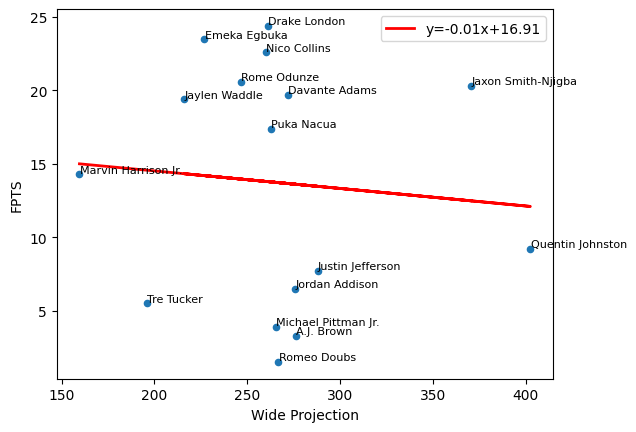

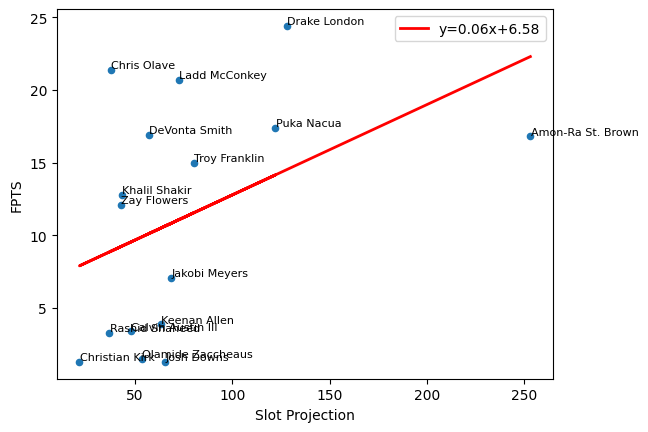

16 Wide Projection correlation: -0.0857

16 Slot Projection correlation: 0.4287



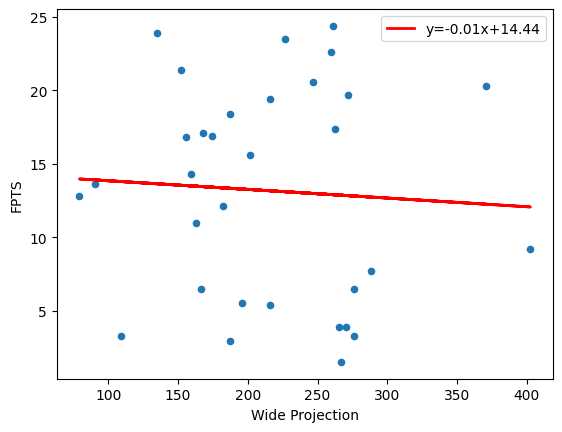

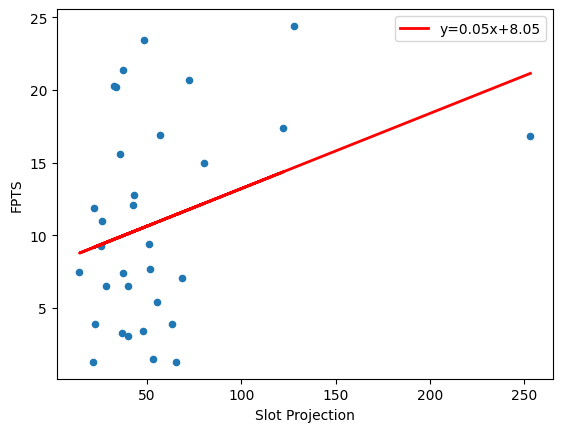

32 Wide Projection correlation: -0.0590

32 Slot Projection correlation: 0.3245



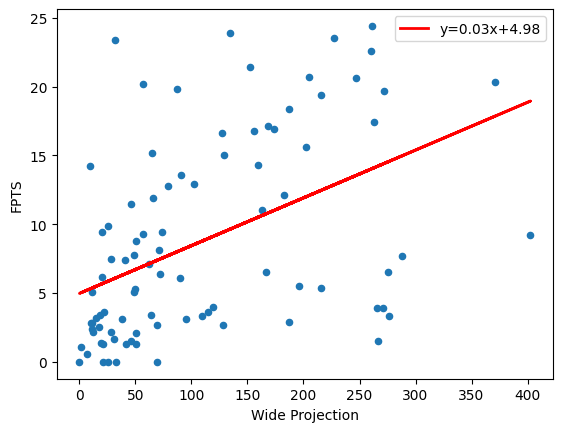

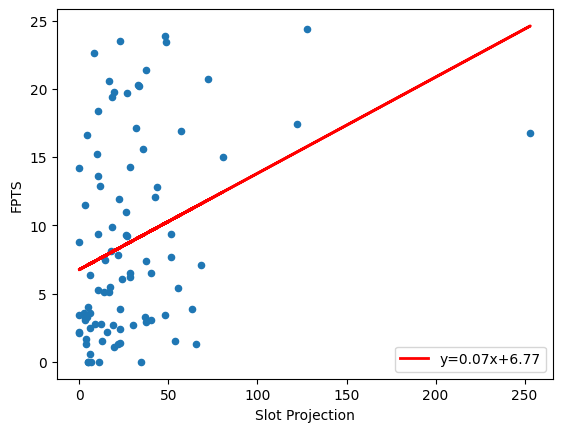

All Wide Projection correlation: 0.4615

All Slot Projection correlation: 0.3330



In [ ]:
# WIDE PROJECTION VS REALITY, SLOT PROJECTION VS REALITY
# DIFF BETWEEN TOP 16, TOP 32, AND ALL

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

wr = pd.read_csv("WR9.csv")
defense = pd.read_csv("Defense9.csv")
defense.rename(columns={"Next Opp": 'Team'}, inplace = True)
wr = wr.merge(defense, how = "inner", on = "Team")
wr = wr.sort_values("Total Points", ascending = False)

results = pd.read_csv("WR9Results.csv")
results.rename(columns = {"NAME": "Player"}, inplace = True)
wr = wr.merge(results, how = "inner", on = "Player")

wr["Slot Projection"] = wr["Slot PPG"] * wr["Slot PPG Allowed"]
wr["Wide Projection"] = wr["Wide PPG"] * wr["Wide PPG Allowed"]
wr["Both Projection"] = wr["Slot Projection"] + wr["Wide Projection"]
wr["Total Projection"] = wr["Total Points"] * wr["Total PPG Allowed"]

# print(wr.to_string())

wr_top16wide = wr.sort_values("Wide PPG", ascending = False).head(16)
wr_top16slot = wr.sort_values("Slot PPG", ascending = False).head(16)

wr_top16wide.plot(kind = "scatter", x = "Wide Projection", y = "FPTS")
b = np.polyfit(wr_top16wide["Wide Projection"], wr_top16wide["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr_top16wide["Wide Projection"], bline(wr_top16wide["Wide Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')
for w, row in wr_top16wide.iterrows():
    plt.text(row["Wide Projection"] + 0.1,
             row["FPTS"] + 0.1,
             row["Player"], fontsize=8)

plt.legend()
plt.show()

wr_top16slot.plot(kind = "scatter", x = "Slot Projection", y = "FPTS")
t = np.polyfit(wr_top16slot["Slot Projection"], wr_top16slot["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr_top16slot["Slot Projection"], tline(wr_top16slot["Slot Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')
for s, row in wr_top16slot.iterrows():
    plt.text(row["Slot Projection"] + 0.1,
             row["FPTS"] + 0.1,
             row["Player"], fontsize=8)

plt.legend()
plt.show()

corr1 = wr_top16wide["Wide Projection"].corr(wr_top16wide["FPTS"])
corr2 = wr_top16slot["Slot Projection"].corr(wr_top16slot["FPTS"])
print(f"16 Wide Projection correlation: {corr1:.4f}\n")
print(f"16 Slot Projection correlation: {corr2:.4f}\n")

wr_top32wide = wr.sort_values("Wide PPG", ascending = False).head(32)
wr_top32slot = wr.sort_values("Slot PPG", ascending = False).head(32)

wr_top32wide.plot(kind = "scatter", x = "Wide Projection", y = "FPTS")
b = np.polyfit(wr_top32wide["Wide Projection"], wr_top32wide["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr_top32wide["Wide Projection"], bline(wr_top32wide["Wide Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')
plt.legend()
plt.show()

wr_top32slot.plot(kind = "scatter", x = "Slot Projection", y = "FPTS")
t = np.polyfit(wr_top32slot["Slot Projection"], wr_top32slot["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr_top32slot["Slot Projection"], tline(wr_top32slot["Slot Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')
plt.legend()
plt.show()

corr1 = wr_top32wide["Wide Projection"].corr(wr_top32wide["FPTS"])
corr2 = wr_top32slot["Slot Projection"].corr(wr_top32slot["FPTS"])
print(f"32 Wide Projection correlation: {corr1:.4f}\n")
print(f"32 Slot Projection correlation: {corr2:.4f}\n")

wr.plot(kind = "scatter", x = "Wide Projection", y = "FPTS")
b = np.polyfit(wr["Wide Projection"], wr["FPTS"], 1)
bline = np.poly1d(b)
plt.plot(wr["Wide Projection"], bline(wr["Wide Projection"]), "r-", linewidth=2, label=f'y={b[0]:.2f}x+{b[1]:.2f}')
plt.legend()
plt.show()

wr.plot(kind = "scatter", x = "Slot Projection", y = "FPTS")
t = np.polyfit(wr["Slot Projection"], wr["FPTS"], 1)
tline = np.poly1d(t)
plt.plot(wr["Slot Projection"], tline(wr["Slot Projection"]), "r-", linewidth=2, label=f'y={t[0]:.2f}x+{t[1]:.2f}')
plt.legend()
plt.show()

corr1 = wr["Wide Projection"].corr(wr["FPTS"])
corr2 = wr["Slot Projection"].corr(wr["FPTS"])
print(f"All Wide Projection correlation: {corr1:.4f}\n")
print(f"All Slot Projection correlation: {corr2:.4f}\n")


# Week 11 Projections

Top 64: Players expected to have more than average Total points (consider starting): 
Jaxon Smith-Njigba
  PPG: 21.90
  Total Projection: 803.73 (Expected: 702.17)
  Diff: 101.56
Ja’Marr Chase
  PPG: 21.00
  Total Projection: 1001.70 (Expected: 673.06)
  Diff: 328.64
George Pickens
  PPG: 17.90
  Total Projection: 651.56 (Expected: 572.80)
  Diff: 78.76
CeeDee Lamb
  PPG: 15.00
  Total Projection: 546.00 (Expected: 478.99)
  Diff: 67.01
DeVonta Smith
  PPG: 14.60
  Total Projection: 496.40 (Expected: 466.06)
  Diff: 30.34
Jaylen Waddle
  PPG: 14.30
  Total Projection: 616.33 (Expected: 456.35)
  Diff: 159.98
Malik Nabers
  PPG: 14.30
  Total Projection: 464.75 (Expected: 456.35)
  Diff: 8.40
Garrett Wilson
  PPG: 14.20
  Total Projection: 454.40 (Expected: 453.12)
  Diff: 1.28
Nico Collins
  PPG: 14.10
  Total Projection: 532.98 (Expected: 449.88)
  Diff: 83.10
Tyreek Hill
  PPG: 13.40
  Total Projection: 577.54 (Expected: 427.24)
  Diff: 150.30
Tee Higgins
  PPG: 12.90
  Total Project

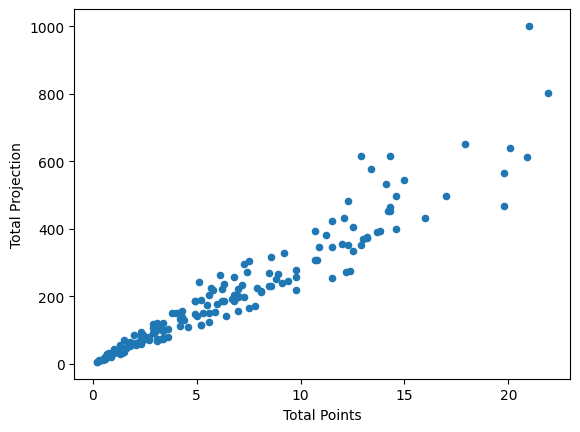

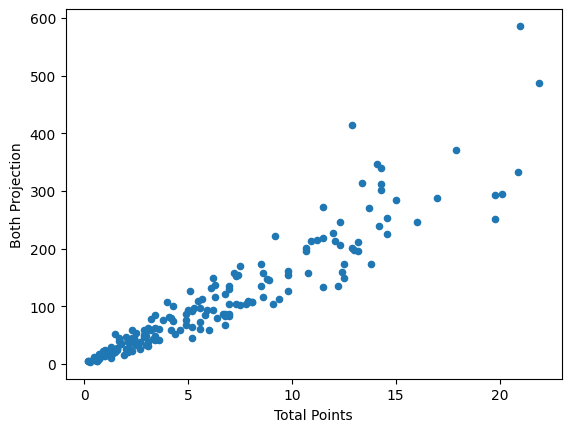

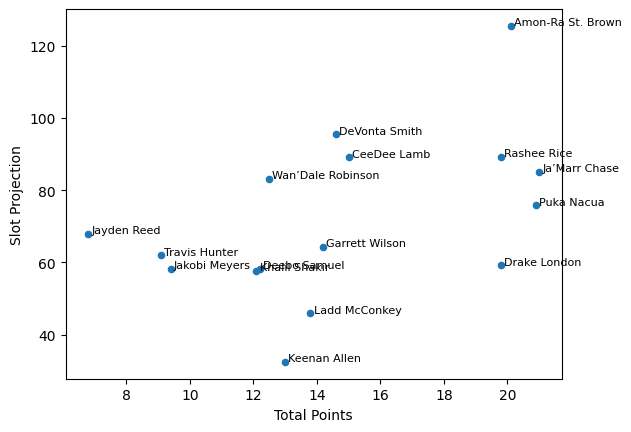

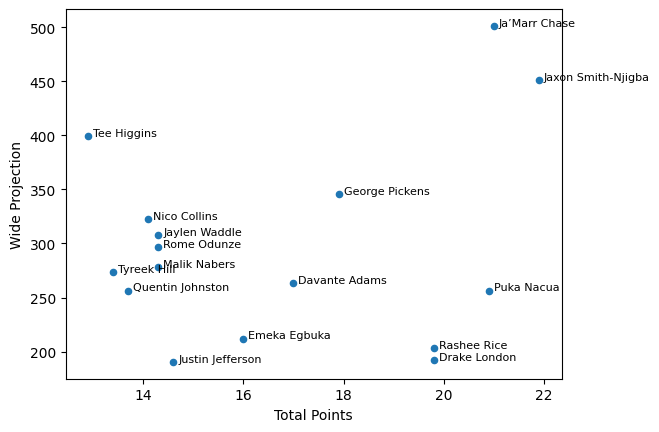

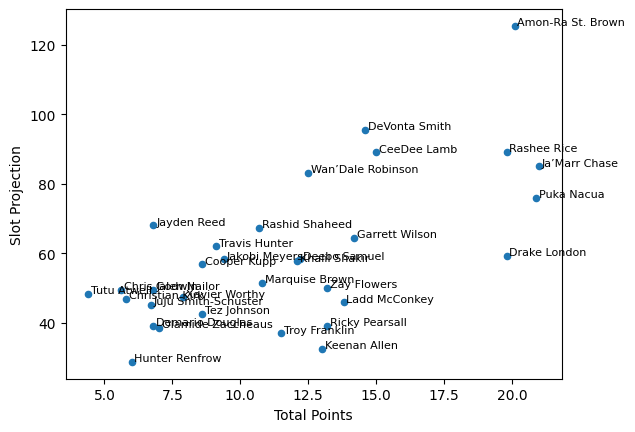

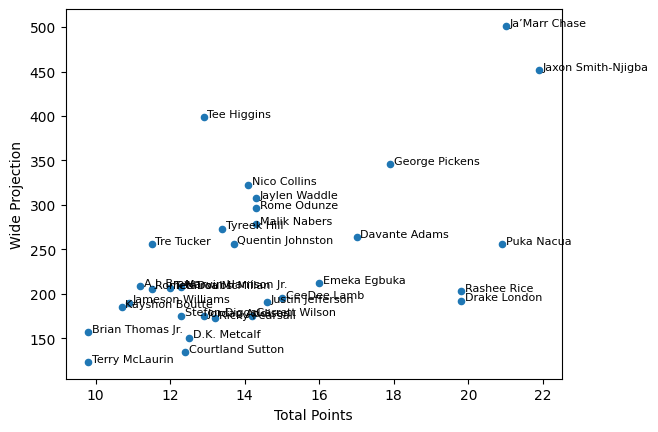

In [ ]:
# MAKING SLOT AND WIDE PROJECTION BASED ON MATCHUP AND PREVIOUS GAMES

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

wr = pd.read_csv("WR10.csv")
defense = pd.read_csv("Defense10.csv")
defense.rename(columns={'Next Opp': 'Team'}, inplace = True)
wr = wr.merge(defense, how = 'inner', on = 'Team')
wr = wr.sort_values('Total Points', ascending = False)

wr["Slot Projection"] = wr["Slot PPG"] * wr["Slot PPG Allowed"]
# wr = wr.sort_values("Slot Projection", ascending=False)
# wr.nlargest(10, "Slot Projection")

wr["Wide Projection"] = wr["Wide PPG"] * wr["Wide PPG Allowed"]
# wr = wr.sort_values("Wide Projection", ascending=False)
# wr.nlargest(10, "Wide Projection")

wr["Total Projection"] = wr["Total Points"] * wr["Total PPG Allowed"]
# wr = wr.sort_values("Total Projection", ascending=False)
# wr.nlargest(10, "Total Projection")

wr["Both Projection"] = wr["Slot Projection"] + wr["Wide Projection"]
# wr = wr.sort_values("Both Projection", ascending=False)
# wr.nlargest(10, "Both Projection")


# print(wr.to_string())

wr_slot = wr.sort_values("Slot PPG", ascending = False)
wr_slot16 = wr_slot.head(16)
wr_slot32 = wr_slot.head(32)

wr_wide = wr.sort_values("Wide PPG", ascending = False)
wr_wide16 = wr_wide.head(16)
wr_wide32 = wr_wide.head(32)


#below is changeable


wr.plot(kind = "scatter", x = "Total Points", y = "Total Projection")
t = np.polyfit(wr["Total Points"], wr["Total Projection"], 1)


# plt.show()


# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]


print("Top 64: Players expected to have more than average Total points (consider starting): ")
for i, row in (wr.head(64)).iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Total Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Total Projection: {row['Total Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Total Projection'] - expected
        print(f"  Diff: {diff:.2f}")


#below is changeable


wr.plot(kind = "scatter", x = "Total Points", y = "Both Projection")
t = np.polyfit(wr["Total Points"], wr["Both Projection"], 1)


# plt.show()


# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]




print("\n\n\nTop 64: Players expected to have more than average Both points (consider starting): ")
for i, row in (wr.head(64)).iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Both Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Both Projection: {row['Both Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Both Projection'] - expected
        print(f"  Diff: {diff:.2f}")



#below is changeable

wr_slot16.plot(kind = "scatter", x = "Total Points", y = "Slot Projection")
t = np.polyfit(wr_slot16["Total Points"], wr_slot16["Slot Projection"], 1)
for s, row in wr_slot16.iterrows():
    plt.text(row["Total Points"] + 0.1,
             row["Slot Projection"] + 0.1,
             row["Player"], fontsize=8)


# plt.show()


# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]


print("\n\n\n16 model: Players expected to have more than average Slot points (consider starting): ")
for i, row in wr_slot16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Slot Projection'] - expected
        print(f"  Diff: {diff:.2f}")


print("\n16 model: Players expected to have less than average Slot points - averaging less than 15 points a game - (consider benching): ")
for i, row in wr_slot16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] < expected and row["Total Points"] < 15:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Slot Projection'] - expected
        print(f"  Diff: {diff:.2f}")


#below is changeable


wr_wide16.plot(kind = "scatter", x = "Total Points", y = "Wide Projection")
t = np.polyfit(wr_wide16["Total Points"], wr_wide16["Wide Projection"], 1)
for s, row in wr_wide16.iterrows():
    plt.text(row["Total Points"] + 0.1,
             row["Wide Projection"] + 0.1,
             row["Player"], fontsize=8)




# plt.show()




# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]




print("\n\n\n16 model: Players expected to have more than average Wide points (consider starting): ")
for i, row in wr_wide16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Wide Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Wide Projection: {row['Wide Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Wide Projection'] - expected
        print(f"  Diff: {diff:.2f}")




print("\n16 model: Players expected to have less than average Wide points - averaging less than 15 points a game - (consider benching): ")
for i, row in wr_wide16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Wide Projection"] < expected and row["Total Points"] < 15:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Wide Projection: {row['Wide Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Wide Projection'] - expected
        print(f"  Diff: {diff:.2f}")


#below is changeable


wr_slot32.plot(kind = "scatter", x = "Total Points", y = "Slot Projection")
t = np.polyfit(wr_slot32["Total Points"], wr_slot32["Slot Projection"], 1)
for s, row in wr_slot32.iterrows():
    plt.text(row["Total Points"] + 0.1,
             row["Slot Projection"] + 0.1,
             row["Player"], fontsize=8)




# plt.show()




# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]




print("\n\n\n32 Model: Players expected to have more than average Slot points (consider starting): ")
for i, row in wr_slot32.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Slot Projection'] - expected
        print(f"  Diff: {diff:.2f}")




print("\n32 Model: Players expected to have less than average Slot points - averaging less than 15 points a game - (consider benching): ")
for i, row in wr_slot32.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] < expected and row["Total Points"] < 15:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Slot Projection'] - expected
        print(f"  Diff: {diff:.2f}")



#below is changeable


wr_wide32.plot(kind = "scatter", x = "Total Points", y = "Wide Projection")
t = np.polyfit(wr_wide32["Total Points"], wr_wide32["Wide Projection"], 1)
for s, row in wr_wide32.iterrows():
    plt.text(row["Total Points"] + 0.1,
             row["Wide Projection"] + 0.1,
             row["Player"], fontsize=8)




# plt.show()




# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]



print("\n\n\n32 Model: Players expected to have more than average Wide points (consider starting): ")
for i, row in wr_wide32.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Wide Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Wide Projection: {row['Wide Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Wide Projection'] - expected
        print(f"  Diff: {diff:.2f}")



print("\n32 Model: Players expected to have less than average Wide points - averaging less than 15 points a game - (consider benching): ")
for i, row in wr_wide32.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Wide Projection"] < expected and row["Total Points"] < 15:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Wide Projection: {row['Wide Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Wide Projection'] - expected
        print(f"  Diff: {diff:.2f}")


# Next changes: projection - use the projected over expected times ppg in both wide and slot, make it accurate by utilizing the mean line from top 16 for top 16, top 32 line for 16-32, and so on, add the two to project points for the week. result - use this projection and compare the points to the result of the week

# Week 13 Projections

Top 64: Players expected to have more than average Total points (consider starting): 
Jaxon Smith-Njigba
  PPG: 23.00
  Total Projection: 713.00 (Expected: 682.90)
  Diff: 30.10
Ja’Marr Chase
  PPG: 19.50
  Total Projection: 585.00 (Expected: 580.25)
  Diff: 4.75
Rashee Rice
  PPG: 18.30
  Total Projection: 633.18 (Expected: 545.06)
  Diff: 88.12
Nico Collins
  PPG: 14.60
  Total Projection: 486.18 (Expected: 436.54)
  Diff: 49.64
Garrett Wilson
  PPG: 14.20
  Total Projection: 485.64 (Expected: 424.81)
  Diff: 60.83
Tetairoa McMillan
  PPG: 13.70
  Total Projection: 468.54 (Expected: 410.15)
  Diff: 58.39
Rome Odunze
  PPG: 13.00
  Total Projection: 395.20 (Expected: 389.62)
  Diff: 5.58
Ladd McConkey
  PPG: 12.90
  Total Projection: 473.43 (Expected: 386.68)
  Diff: 86.75
Tee Higgins
  PPG: 12.70
  Total Projection: 381.00 (Expected: 380.82)
  Diff: 0.18
Keenan Allen
  PPG: 12.70
  Total Projection: 466.09 (Expected: 380.82)
  Diff: 85.27
Marvin Harrison Jr.
  PPG: 12.30
  Total Proj

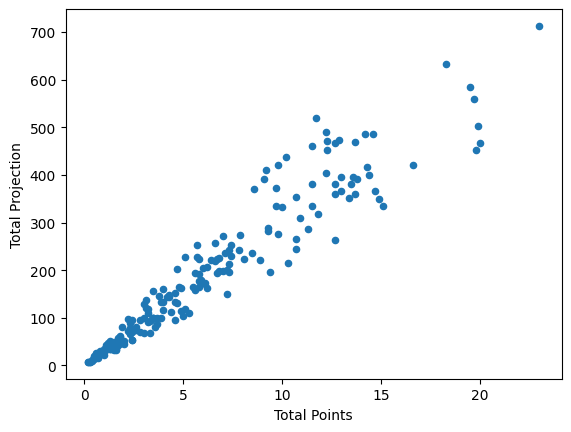

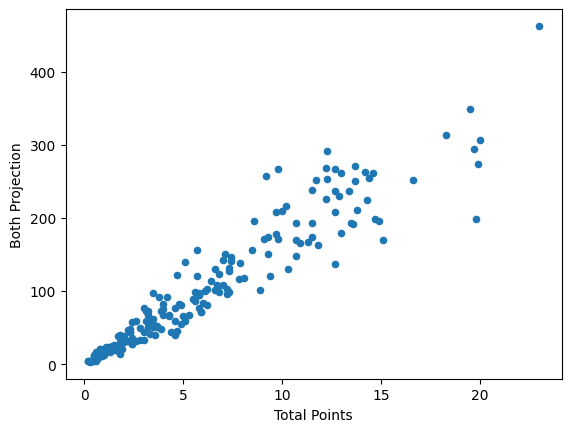

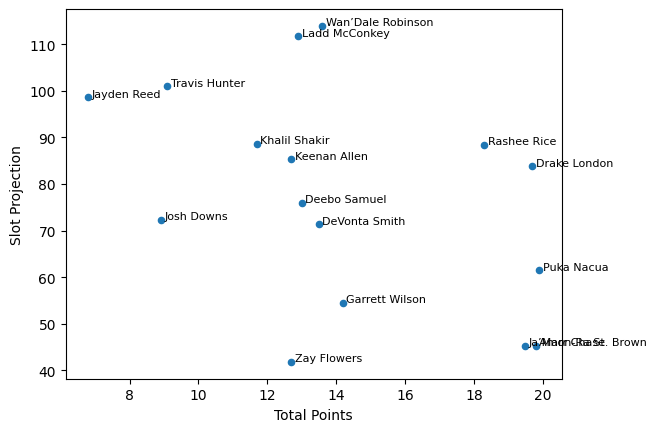

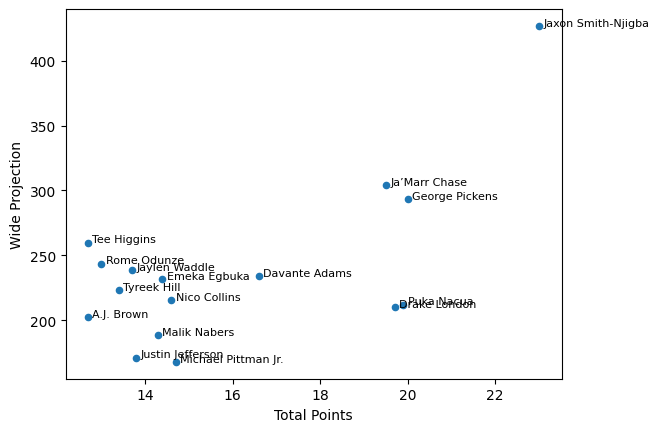

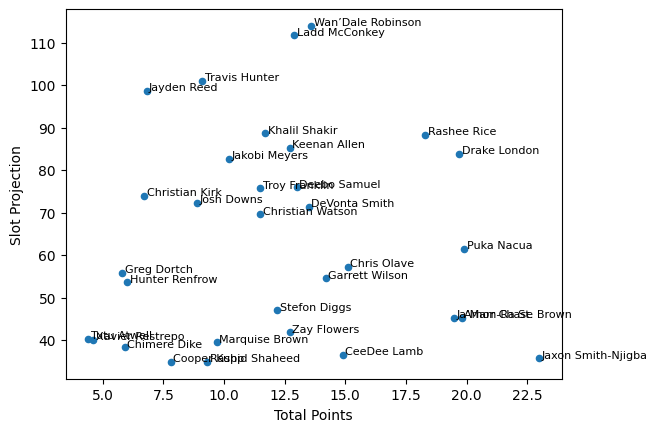

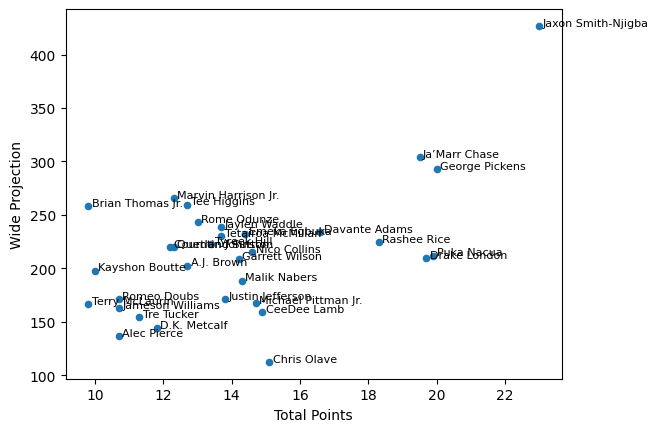

In [ ]:
# MAKING SLOT AND WIDE PROJECTION BASED ON MATCHUP AND PREVIOUS GAMES

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

wr = pd.read_csv("WR12.csv")
defense = pd.read_csv("Defense12.csv")
defense.rename(columns={'Next Opp': 'Team'}, inplace = True)
wr = wr.merge(defense, how = 'inner', on = 'Team')
wr = wr.sort_values('Total Points', ascending = False)

wr["Slot Projection"] = wr["Slot PPG"] * wr["Slot PPG Allowed"]
# wr = wr.sort_values("Slot Projection", ascending=False)
# wr.nlargest(10, "Slot Projection")

wr["Wide Projection"] = wr["Wide PPG"] * wr["Wide PPG Allowed"]
# wr = wr.sort_values("Wide Projection", ascending=False)
# wr.nlargest(10, "Wide Projection")

wr["Total Projection"] = wr["Total Points"] * wr["Total PPG Allowed"]
# wr = wr.sort_values("Total Projection", ascending=False)
# wr.nlargest(10, "Total Projection")

wr["Both Projection"] = wr["Slot Projection"] + wr["Wide Projection"]
# wr = wr.sort_values("Both Projection", ascending=False)
# wr.nlargest(10, "Both Projection")


# print(wr.to_string())

wr_slot = wr.sort_values("Slot PPG", ascending = False)
wr_slot16 = wr_slot.head(16)
wr_slot32 = wr_slot.head(32)

wr_wide = wr.sort_values("Wide PPG", ascending = False)
wr_wide16 = wr_wide.head(16)
wr_wide32 = wr_wide.head(32)


#below is changeable


wr.plot(kind = "scatter", x = "Total Points", y = "Total Projection")
t = np.polyfit(wr["Total Points"], wr["Total Projection"], 1)


# plt.show()


# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]


print("Top 64: Players expected to have more than average Total points (consider starting): ")
for i, row in (wr.head(64)).iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Total Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Total Projection: {row['Total Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Total Projection'] - expected
        print(f"  Diff: {diff:.2f}")


#below is changeable


wr.plot(kind = "scatter", x = "Total Points", y = "Both Projection")
t = np.polyfit(wr["Total Points"], wr["Both Projection"], 1)


# plt.show()


# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]




print("\n\n\nTop 64: Players expected to have more than average Both points (consider starting): ")
for i, row in (wr.head(64)).iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Both Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Both Projection: {row['Both Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Both Projection'] - expected
        print(f"  Diff: {diff:.2f}")



#below is changeable

wr_slot16.plot(kind = "scatter", x = "Total Points", y = "Slot Projection")
t = np.polyfit(wr_slot16["Total Points"], wr_slot16["Slot Projection"], 1)
for s, row in wr_slot16.iterrows():
    plt.text(row["Total Points"] + 0.1,
             row["Slot Projection"] + 0.1,
             row["Player"], fontsize=8)


# plt.show()


# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]


print("\n\n\n16 model: Players expected to have more than average Slot points (consider starting): ")
for i, row in wr_slot16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Slot Projection'] - expected
        print(f"  Diff: {diff:.2f}")


print("\n16 model: Players expected to have less than average Slot points - averaging less than 15 points a game - (consider benching): ")
for i, row in wr_slot16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] < expected and row["Total Points"] < 15:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Slot Projection'] - expected
        print(f"  Diff: {diff:.2f}")


#below is changeable


wr_wide16.plot(kind = "scatter", x = "Total Points", y = "Wide Projection")
t = np.polyfit(wr_wide16["Total Points"], wr_wide16["Wide Projection"], 1)
for s, row in wr_wide16.iterrows():
    plt.text(row["Total Points"] + 0.1,
             row["Wide Projection"] + 0.1,
             row["Player"], fontsize=8)




# plt.show()




# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]




print("\n\n\n16 model: Players expected to have more than average Wide points (consider starting): ")
for i, row in wr_wide16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Wide Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Wide Projection: {row['Wide Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Wide Projection'] - expected
        print(f"  Diff: {diff:.2f}")




print("\n16 model: Players expected to have less than average Wide points - averaging less than 15 points a game - (consider benching): ")
for i, row in wr_wide16.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Wide Projection"] < expected and row["Total Points"] < 15:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Wide Projection: {row['Wide Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Wide Projection'] - expected
        print(f"  Diff: {diff:.2f}")


#below is changeable


wr_slot32.plot(kind = "scatter", x = "Total Points", y = "Slot Projection")
t = np.polyfit(wr_slot32["Total Points"], wr_slot32["Slot Projection"], 1)
for s, row in wr_slot32.iterrows():
    plt.text(row["Total Points"] + 0.1,
             row["Slot Projection"] + 0.1,
             row["Player"], fontsize=8)




# plt.show()




# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]




print("\n\n\n32 Model: Players expected to have more than average Slot points (consider starting): ")
for i, row in wr_slot32.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Slot Projection'] - expected
        print(f"  Diff: {diff:.2f}")




print("\n32 Model: Players expected to have less than average Slot points - averaging less than 15 points a game - (consider benching): ")
for i, row in wr_slot32.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Slot Projection"] < expected and row["Total Points"] < 15:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Slot Projection: {row['Slot Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Slot Projection'] - expected
        print(f"  Diff: {diff:.2f}")



#below is changeable


wr_wide32.plot(kind = "scatter", x = "Total Points", y = "Wide Projection")
t = np.polyfit(wr_wide32["Total Points"], wr_wide32["Wide Projection"], 1)
for s, row in wr_wide32.iterrows():
    plt.text(row["Total Points"] + 0.1,
             row["Wide Projection"] + 0.1,
             row["Player"], fontsize=8)




# plt.show()




# Use the line of best fit coefficients instead of hardcoded values
slope = t[0]
intercept = t[1]



print("\n\n\n32 Model: Players expected to have more than average Wide points (consider starting): ")
for i, row in wr_wide32.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Wide Projection"] > expected:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Wide Projection: {row['Wide Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Wide Projection'] - expected
        print(f"  Diff: {diff:.2f}")



print("\n32 Model: Players expected to have less than average Wide points - averaging less than 15 points a game - (consider benching): ")
for i, row in wr_wide32.iterrows():
    expected = slope * row["Total Points"] + intercept
    if row["Wide Projection"] < expected and row["Total Points"] < 15:
        print(row["Player"])
        print(f"  PPG: {row['Total Points']:.2f}")
        print(f"  Wide Projection: {row['Wide Projection']:.2f} (Expected: {expected:.2f})")
        diff = row['Wide Projection'] - expected
        print(f"  Diff: {diff:.2f}")


# Week 13 Projections

Top 64: Players expected to have more than average Total points (consider starting): 
Jaxon Smith-Njigba
  PPG: 21.90
  Total Projection: 803.73 (Expected: 702.17)
  Diff: 101.56
Ja’Marr Chase
  PPG: 21.00
  Total Projection: 1001.70 (Expected: 673.06)
  Diff: 328.64
George Pickens
  PPG: 17.90
  Total Projection: 651.56 (Expected: 572.80)
  Diff: 78.76
CeeDee Lamb
  PPG: 15.00
  Total Projection: 546.00 (Expected: 478.99)
  Diff: 67.01
DeVonta Smith
  PPG: 14.60
  Total Projection: 496.40 (Expected: 466.06)
  Diff: 30.34
Jaylen Waddle
  PPG: 14.30
  Total Projection: 616.33 (Expected: 456.35)
  Diff: 159.98
Malik Nabers
  PPG: 14.30
  Total Projection: 464.75 (Expected: 456.35)
  Diff: 8.40
Garrett Wilson
  PPG: 14.20
  Total Projection: 454.40 (Expected: 453.12)
  Diff: 1.28
Nico Collins
  PPG: 14.10
  Total Projection: 532.98 (Expected: 449.88)
  Diff: 83.10
Tyreek Hill
  PPG: 13.40
  Total Projection: 577.54 (Expected: 427.24)
  Diff: 150.30
Tee Higgins
  PPG: 12.90
  Total Project

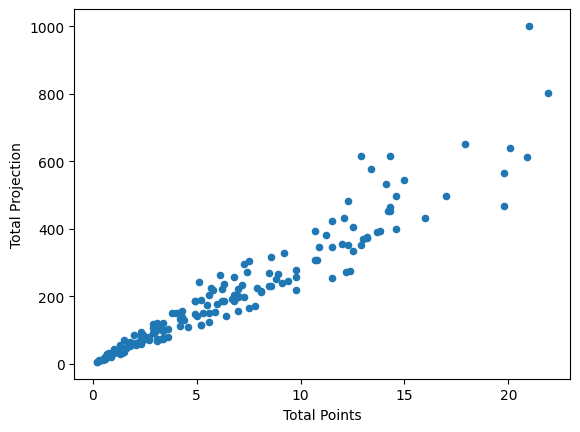

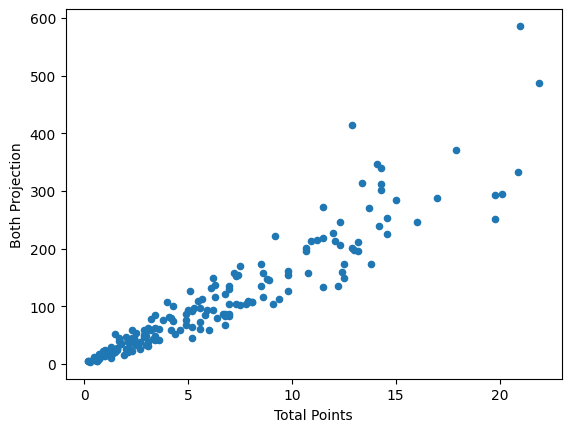

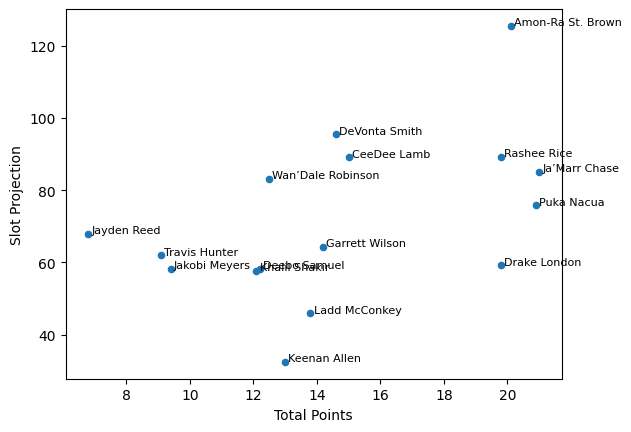

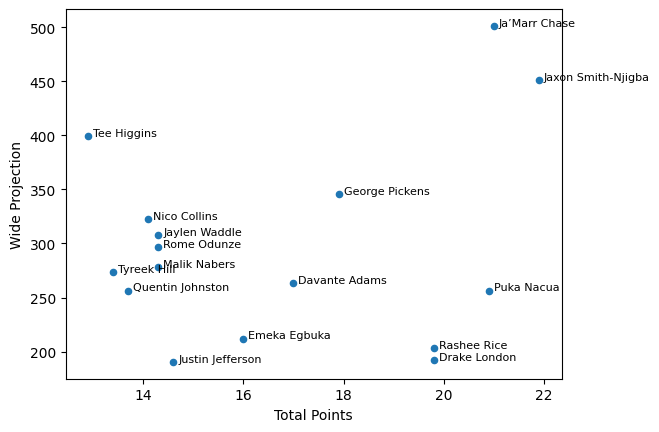

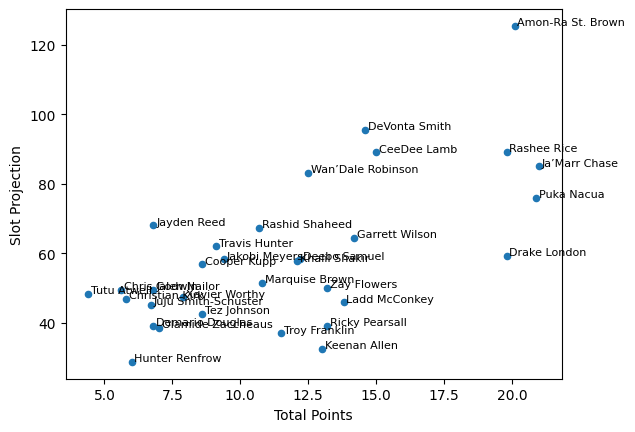

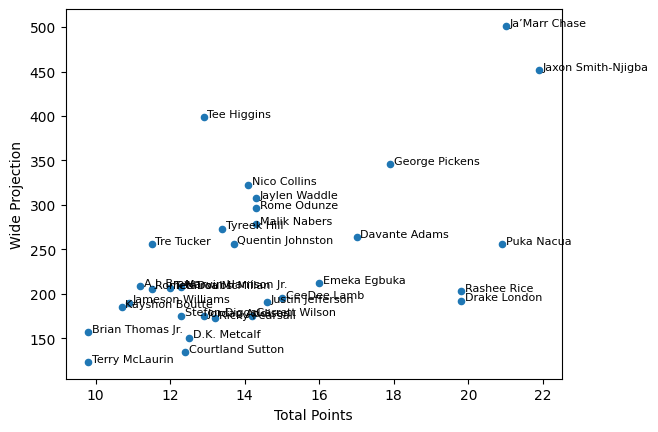

# Week 13 Projections

WEEKLY PROJECTIONS - TOP 32 WIDE RECEIVERS
Rank  Player                   PPG     Proj    Diff    Slot Adj  Wide Adj  
------------------------------------------------------------------------------------------
1     Jaxon Smith-Njigba       23.00   27.88   4.88    3.15      24.74     
2     Rashee Rice              18.30   22.60   4.30    12.39     10.20     
3     Drake London             19.70   19.37   -0.33   10.95     8.42      
4     George Pickens           20.00   19.18   -0.82   0.64      18.54     
5     Ja’Marr Chase            19.50   18.89   -0.61   4.10      14.80     
6     Tetairoa McMillan        13.70   16.24   2.54    4.06      12.18     
7     Puka Nacua               19.90   16.23   -3.67   6.24      9.99      
8     Amon-Ra St. Brown        19.80   15.88   -3.92   8.30      7.59      
9     Marvin Harrison Jr.      12.30   15.84   3.54    1.40      14.45     
10    Tee Higgins              12.70   15.48   2.78    0.17      15.30     
11    Keon Coleman            

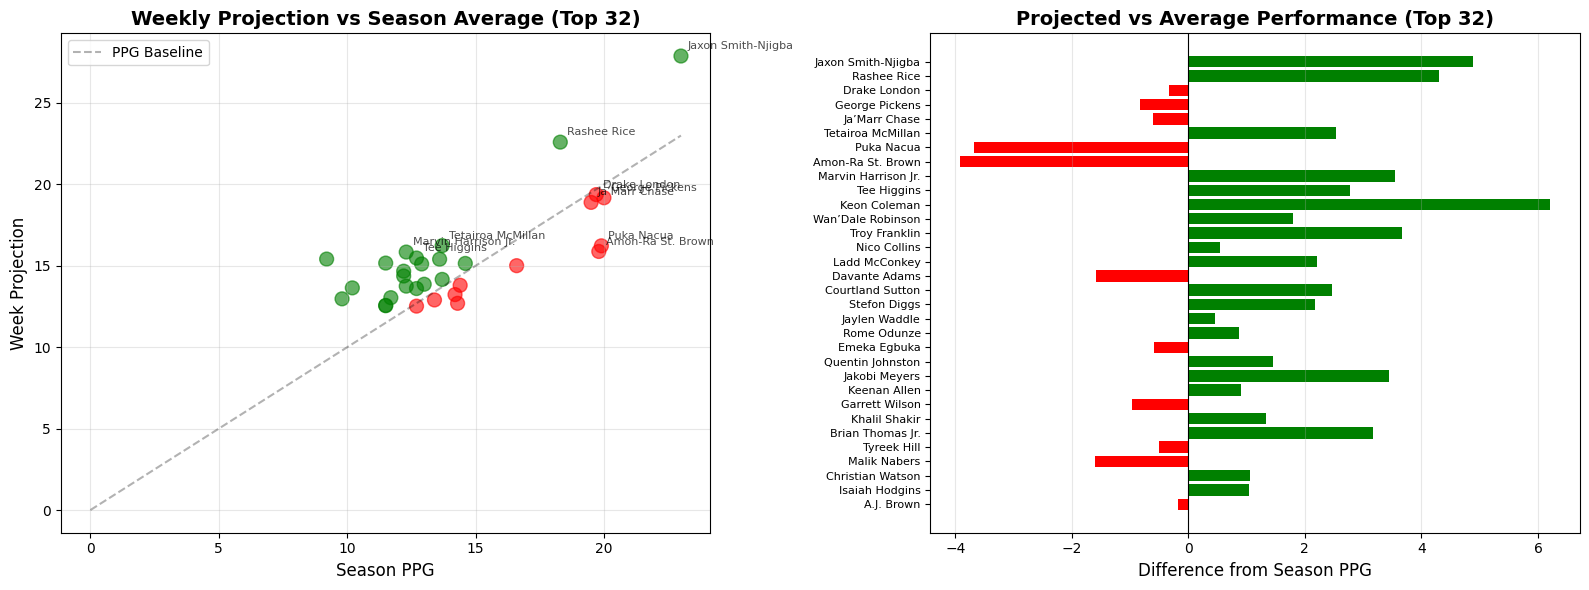


SUMMARY STATISTICS
Average projection for top 32: 15.41 points
Average PPG for top 32: 14.28 points
Players projected above average: 21
Players projected below average: 11
Highest projection: Jaxon Smith-Njigba (27.88)
Biggest positive difference: Keon Coleman (+6.21)
Biggest negative difference: Amon-Ra St. Brown (-3.92)


In [ ]:
# TIERED WIDE RECEIVER PROJECTION SYSTEM
# Combines Slot and Wide projections using tier-specific regression lines

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load and merge data
wr = pd.read_csv("WR12.csv")
defense = pd.read_csv("Defense12.csv")
defense.rename(columns={'Next Opp': 'Team'}, inplace=True)
wr = wr.merge(defense, how='inner', on='Team')
wr = wr.sort_values('Total Points', ascending=False)

# Calculate projections
wr["Slot Projection"] = wr["Slot PPG"] * wr["Slot PPG Allowed"]
wr["Wide Projection"] = wr["Wide PPG"] * wr["Wide PPG Allowed"]

# Sort by position type
wr_slot = wr.sort_values("Slot PPG", ascending=False).reset_index(drop=True)
wr_wide = wr.sort_values("Wide PPG", ascending=False).reset_index(drop=True)

# Function to calculate tier-specific regression
def get_tier_regression(df, tier_start, tier_end, projection_col):
    """Calculate regression line for a specific tier"""
    tier_data = df.iloc[tier_start:tier_end]
    if len(tier_data) > 1:
        coeffs = np.polyfit(tier_data["Total Points"], tier_data[projection_col], 1)
        return coeffs[0], coeffs[1]  # slope, intercept
    return 1, 0  # default if not enough data

# Calculate tier-specific regressions for Slot
slot_tier1_slope, slot_tier1_int = get_tier_regression(wr_slot, 0, 16, "Slot Projection")
slot_tier2_slope, slot_tier2_int = get_tier_regression(wr_slot, 16, 32, "Slot Projection")
slot_tier3_slope, slot_tier3_int = get_tier_regression(wr_slot, 32, 64, "Slot Projection")

# Calculate tier-specific regressions for Wide
wide_tier1_slope, wide_tier1_int = get_tier_regression(wr_wide, 0, 16, "Wide Projection")
wide_tier2_slope, wide_tier2_int = get_tier_regression(wr_wide, 16, 32, "Wide Projection")
wide_tier3_slope, wide_tier3_int = get_tier_regression(wr_wide, 32, 64, "Wide Projection")

# Function to get expected value based on tier
def get_expected_value(rank, ppg, slope_t1, int_t1, slope_t2, int_t2, slope_t3, int_t3):
    """Get expected value based on player's tier"""
    if rank < 16:
        return slope_t1 * ppg + int_t1
    elif rank < 32:
        return slope_t2 * ppg + int_t2
    else:
        return slope_t3 * ppg + int_t3

# Calculate projections for each player
results = []

for idx, player_row in wr.iterrows():
    player_name = player_row["Player"]
    ppg = player_row["Total Points"]
    slot_ppg = player_row["Slot PPG"]
    wide_ppg = player_row["Wide PPG"]

    # Find player's rank in slot and wide
    slot_rank = wr_slot[wr_slot["Player"] == player_name].index[0] if player_name in wr_slot["Player"].values else 999
    wide_rank = wr_wide[wr_wide["Player"] == player_name].index[0] if player_name in wr_wide["Player"].values else 999

    # Get actual projections
    slot_proj = player_row["Slot Projection"]
    wide_proj = player_row["Wide Projection"]

    # Get expected values based on tier (point on line of best fit)
    slot_expected = get_expected_value(slot_rank, ppg, slot_tier1_slope, slot_tier1_int,
                                       slot_tier2_slope, slot_tier2_int, slot_tier3_slope, slot_tier3_int)
    wide_expected = get_expected_value(wide_rank, ppg, wide_tier1_slope, wide_tier1_int,
                                       wide_tier2_slope, wide_tier2_int, wide_tier3_slope, wide_tier3_int)

    # Divide projection by expected (line of best fit), then multiply by respective PPG
    if slot_expected > 0:
        slot_adjusted = (slot_proj / slot_expected) * slot_ppg
    else:
        slot_adjusted = slot_ppg

    if wide_expected > 0:
        wide_adjusted = (wide_proj / wide_expected) * wide_ppg
    else:
        wide_adjusted = wide_ppg

    # Add the two together for weekly projection
    weekly_projection = slot_adjusted + wide_adjusted

    results.append({
        'Player': player_name,
        'PPG': ppg,
        'Slot PPG': slot_ppg,
        'Wide PPG': wide_ppg,
        'Slot Rank': slot_rank + 1,
        'Wide Rank': wide_rank + 1,
        'Slot Multiplier': slot_proj / slot_expected if slot_expected > 0 else 1,
        'Wide Multiplier': wide_proj / wide_expected if wide_expected > 0 else 1,
        'Slot Adjusted': slot_adjusted,
        'Wide Adjusted': wide_adjusted,
        'Week Projection': weekly_projection,
        'Difference': weekly_projection - ppg
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Week Projection', ascending=False).reset_index(drop=True)

# Display top 32 projections
print("=" * 90)
print("WEEKLY PROJECTIONS - TOP 32 WIDE RECEIVERS")
print("=" * 90)
print(f"{'Rank':<6}{'Player':<25}{'PPG':<8}{'Proj':<8}{'Diff':<8}{'Slot Adj':<10}{'Wide Adj':<10}")
print("-" * 90)

for idx, row in results_df.head(32).iterrows():
    print(f"{idx+1:<6}{row['Player']:<25}{row['PPG']:<8.2f}{row['Week Projection']:<8.2f}"
          f"{row['Difference']:<8.2f}{row['Slot Adjusted']:<10.2f}{row['Wide Adjusted']:<10.2f}")

# Display ranks 32-64
print("\n" + "=" * 90)
print("WEEKLY PROJECTIONS - RANKS 33-64 WIDE RECEIVERS")
print("=" * 90)
print(f"{'Rank':<6}{'Player':<25}{'PPG':<8}{'Proj':<8}{'Diff':<8}{'Slot Adj':<10}{'Wide Adj':<10}")
print("-" * 90)

for idx, row in results_df.iloc[32:64].iterrows():
    print(f"{idx+1:<6}{row['Player']:<25}{row['PPG']:<8.2f}{row['Week Projection']:<8.2f}"
          f"{row['Difference']:<8.2f}{row['Slot Adjusted']:<10.2f}{row['Wide Adjusted']:<10.2f}")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Week Projection vs PPG
top_32 = results_df.head(32)
colors = ['green' if diff > 0 else 'red' for diff in top_32['Difference']]
ax1.scatter(top_32['PPG'], top_32['Week Projection'], c=colors, alpha=0.6, s=100)
ax1.plot([0, top_32['PPG'].max()], [0, top_32['PPG'].max()], 'k--', alpha=0.3, label='PPG Baseline')
ax1.set_xlabel('Season PPG', fontsize=12)
ax1.set_ylabel('Week Projection', fontsize=12)
ax1.set_title('Weekly Projection vs Season Average (Top 32)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add player labels for top 10
for idx, row in top_32.head(10).iterrows():
    ax1.annotate(row['Player'], (row['PPG'], row['Week Projection']),
                fontsize=8, alpha=0.7, xytext=(5, 5), textcoords='offset points')

# Plot 2: Difference from PPG
ax2.barh(range(len(top_32)), top_32['Difference'],
         color=['green' if x > 0 else 'red' for x in top_32['Difference']])
ax2.set_yticks(range(len(top_32)))
ax2.set_yticklabels(top_32['Player'], fontsize=8)
ax2.set_xlabel('Difference from Season PPG', fontsize=12)
ax2.set_title('Projected vs Average Performance (Top 32)', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 90)
print("SUMMARY STATISTICS")
print("=" * 90)
print(f"Average projection for top 32: {top_32['Week Projection'].mean():.2f} points")
print(f"Average PPG for top 32: {top_32['PPG'].mean():.2f} points")
print(f"Players projected above average: {len(top_32[top_32['Difference'] > 0])}")
print(f"Players projected below average: {len(top_32[top_32['Difference'] < 0])}")
print(f"Highest projection: {top_32['Player'].iloc[0]} ({top_32['Week Projection'].iloc[0]:.2f})")
print(f"Biggest positive difference: {top_32['Player'].iloc[top_32['Difference'].idxmax()]} (+{top_32['Difference'].max():.2f})")
print(f"Biggest negative difference: {top_32['Player'].iloc[top_32['Difference'].idxmin()]} ({top_32['Difference'].min():.2f})")